# Notes nn - Predictors of recorded DS live births

- Drop calibration (makes no difference)


## Preparation


In [1]:
import joblib, optuna, os, shap
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from lightgbm import early_stopping, log_evaluation
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    brier_score_loss,
    log_loss,
)
from sklearn.model_selection import train_test_split

import repl_utils, stats_utils, data_utils, ml_utils, plot_utils
from variables import Variables as vars

pd.options.mode.copy_on_write = True

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = 47
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)

N_CORES = joblib.cpu_count(only_physical_cores=True)

START_TIME = datetime.now()

OUTPUT_DIR = f"output/0009-predictors-9/{START_TIME:%Y%m%d-%H%M%S}"

os.makedirs(OUTPUT_DIR, exist_ok=True)

repl_utils.print_environment_info()

print(f"\n--------------------\nOutput directory: {OUTPUT_DIR}\n--------------------\n")

v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\arviz\__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


-------------------- Environment Information --------------------
date: 2025-12-31T19:21:36.560401
platform: Windows-11-10.0.26220-SP0
platform_version: 10.0.26220
cpu: Intel64 Family 6 Model 197 Stepping 2, GenuineIntel
cores: 16
physical_cores: 16
ram: 95 GB
ram_available: 75 GB
cuda: False
cuda_device_count: 0
cuda_device_0: False
python: 3.13.11 | packaged by conda-forge | (main, Dec  6 2025, 11:10:00) [MSC v.1944 64 bit (AMD64)]
numpy: 2.3.5
pandas: 2.3.3
scipy: 1.16.3
sklearn: 1.8.0
lightgbm: 4.6.0
pytorch: 2.9.1
pymc: 5.27.0
pytensor: 2.36.1
arviz: 0.23.0

--------------------
Output directory: output/0009-predictors-9/20251231-192136
--------------------



### Options


In [ ]:
START_YEAR = 2016
END_YEAR = 2024
# LightGBM threads
NUM_THREADS = N_CORES - 2
# Splitting data for training, validation and calibration
TRAINING_SPLIT = 0.7
VALIDATION_SPLIT = 0.3
# CALIBRATION_SPLIT = 1 - TRAINING_SPLIT - VALIDATION_SPLIT
#
NUM_BOOST_ROUND = 10000
EARLY_STOPPING_ROUNDS = 50
# True to search for hyperparameters
SELECT_HYPERPARAMETERS = True
#
OPTIMIZE_TRIALS = 50

SAVE_PLOTS = True

### Load data


In [3]:
df = data_utils.load_predictors_data(
    from_year=START_YEAR, to_year=END_YEAR, include_unknown=True
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### Define initial feature set


In [4]:
numeric = [
    vars.YEAR,
    vars.DBWT,
    # vars.PWGT_R,
    vars.WTGAIN,
    vars.BMI,
    vars.MAGE_C,
    vars.FAGECOMB,
]

categorical = [
    # vars.DOB_MM,
    # vars.DOB_WK,
    # "dob_tt_pm",
    vars.BFACIL3,
    vars.SEX,
    vars.PRECARE,
    vars.GESTREC10,
    vars.RF_PDIAB,
    vars.RF_GDIAB,
    vars.RF_PHYPE,
    vars.RF_GHYPE,
    vars.RF_EHYPE,
    vars.RF_PPTERM,
    vars.RF_INFTR,
    vars.RF_FEDRG,
    vars.RF_ARTEC,
    # vars.NO_RISKS,
    vars.LD_INDL,
    vars.LD_AUGM,
    vars.ME_PRES,
    vars.DMETH_REC,
    vars.APGAR5,
    vars.APGAR10,
    vars.AB_AVEN1,
    vars.AB_AVEN6,
    vars.AB_NICU,
    vars.AB_SURF,
    vars.AB_ANTI,
    vars.AB_SEIZ,
    # vars.NO_ABNORM,
    vars.CA_ANEN,
    vars.CA_MNSB,
    vars.CA_CCHD,
    vars.CA_CDH,
    vars.CA_OMPH,
    vars.CA_GAST,
    vars.CA_LIMB,
    vars.CA_CLEFT,
    vars.CA_CLPAL,
    vars.CA_HYPO,
    vars.CA_DISOR,
    # vars.NO_CONGEN,
    vars.MEDUC,
    vars.MRACEHISP,
    vars.FEDUC,
    vars.FRACEHISP,
    vars.PAY_REC,
    vars.WIC,
]

features = categorical + numeric

X = df[features]
y = df["ca_down_c_p_n"].replace({pd.NA: 0, np.nan: 0}).astype(np.int32)

X[categorical] = X[categorical].astype("category")

### Split training, validation and calibration data


In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=(1-TRAINING_SPLIT), stratify=y, random_state=RANDOM_SEED
)

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

In [6]:
neg_count_train = y_train[y_train == 0].count()
pos_count_train = y_train[y_train == 1].count()
# scale_pos_weight = neg_count_train / pos_count_train

neg_count_valid = y_valid[y_valid == 0].count()
pos_count_valid = y_valid[y_valid == 1].count()

print(
    f"Training set: {neg_count_train} negatives, {pos_count_train} positives, probability positive {pos_count_train / neg_count_train:.8f}"
)
print(
    f"Validation set: {neg_count_valid} negatives, {pos_count_valid} positives, probability positive {pos_count_valid / neg_count_valid:.8f}"
)

Training set: 23499993 negatives, 12466 positives, probability positive 0.00053047
Validation set: 10071426 negatives, 5343 positives, probability positive 0.00053051


In [ ]:
base_params = {
    "objective": "binary",
    "metric": ["average_precision", "binary_logloss"],
    "boosting_type": "gbdt",
    "max_bin": 255,  # GPU 63/127; CPU 255
    # for now, we do not scale for better interpretability of outputs
    "scale_pos_weight": 1,
    "force_col_wise": True,
    "seed": RANDOM_SEED,
    "num_threads": NUM_THREADS,
    "verbosity": 1,
}

last_best_params = {
    "learning_rate": 0.009461164726049449,
    "num_leaves": 180,
    "min_data_in_leaf": 756,
    "min_gain_to_split": 0.9285634625013361,
    "feature_fraction": 0.9239582799934513,
    "bagging_fraction": 0.9185684081749333,
    "bagging_freq": 2,
    "lambda_l1": 0.0005836073944757167,
    "lambda_l2": 0.6142323696066677
}

## Hyperparameter tuning


In [8]:
def objective(trial):
    trial_params = {
        # required to change min_data_in_leaf across trials without rebuilding the Dataset
        "feature_pre_filter": False,
        # Speed / stability
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.75, log=True),
        # Tree complexity
        "num_leaves": trial.suggest_int("num_leaves", 32, 512, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 500, 10000, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 1.0),
        # Sampling
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        # Regularization
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    }

    # Merge: base_params always present; trial_params override if same key exists
    params = {**base_params, **trial_params}

    pruning_cb = optuna.integration.LightGBMPruningCallback(trial, "average_precision")

    gbm = lgb.train(
        params,
        train_data,
        num_boost_round=NUM_BOOST_ROUND,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
            lgb.log_evaluation(period=10),
            pruning_cb,
        ],
    )

    # Best score on validation
    return gbm.best_score["valid_0"]["average_precision"]


if SELECT_HYPERPARAMETERS:
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.HyperbandPruner(),
    )

    study.optimize(objective, n_trials=OPTIMIZE_TRIALS)

    print(study.best_params, study.best_value)

    best = study.best_params
else:
    best = last_best_params

# Merge (best overrides base if there are collisions)
params = {**base_params, **best}
params["feature_pre_filter"] = True  # reset to default for final training

print("Parameters for training:")
for k, v in params.items():
    print(f'  "{k}": {v}')

[I 2025-12-31 19:22:28,878] A new study created in memory with name: no-name-c6dc0c57-a3e0-4f71-a6e1-4c9fd4da3b0d


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's average_precision: 0.0177644	valid_0's binary_logloss: 0.00381855
[20]	valid_0's average_precision: 0.0194586	valid_0's binary_logloss: 0.00377211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's average_precision: 0.0196812	valid_0's binary_logloss: 0.00378124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-12-31 19:24:28,419] Trial 0 finished with value: 0.019935297645889083 and parameters: {'learning_rate': 0.2411703116885172, 'num_leaves': 375, 'min_data_in_leaf': 7535, 'min_gain_to_split': 0.9125061070623299, 'feature_fraction': 0.6539569947904568, 'bagging_fraction': 0.8966291427268094, 'bagging_freq': 5, 'lambda_l1': 0.00026216950786996107, 'lambda_l2': 0.5444139011384784}. Best is trial 0 with value: 0.019935297645889083.


Early stopping, best iteration is:
[21]	valid_0's average_precision: 0.0199353	valid_0's binary_logloss: 0.00376712
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0253786	valid_0's binary_logloss: 0.00424726
[20]	valid_0's average_precision: 0.0265004	valid_0's binary_logloss: 0.00412239
[30]	valid_0's average_precision: 0.0268525	valid_0's binary_logloss: 0.0040415
[40]	valid_0's average_precision: 0.0272499	valid_0's binary_logloss: 0.00397658
[50]	valid_0's average_precision: 0.0274712	valid_0's binary_logloss: 0.00392934
[60]	valid_0's average_precision: 0.0278426	valid_0's binary_logloss: 0.00388869
[

[I 2025-12-31 19:40:25,759] Trial 1 finished with value: 0.030295887309142323 and parameters: {'learning_rate': 0.008011462996589318, 'num_leaves': 191, 'min_data_in_leaf': 505, 'min_gain_to_split': 0.30371927847110114, 'feature_fraction': 0.6661781654619054, 'bagging_fraction': 0.8647963250573254, 'bagging_freq': 3, 'lambda_l1': 2.2707928379713444e-06, 'lambda_l2': 0.20643050105638783}. Best is trial 1 with value: 0.030295887309142323.


Early stopping, best iteration is:
[653]	valid_0's average_precision: 0.0302959	valid_0's binary_logloss: 0.00361508
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 19:40:29,001] Trial 2 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0252795	valid_0's binary_logloss: 0.00426725
[20]	valid_0's average_precision: 0.0257584	valid_0's binary_logloss: 0.00416072
[30]	valid_0's average_precision: 0.0263835	valid_0's binary_logloss: 0.00408511
[40]	valid_0's average_precision: 0.0269425	valid_0's binary_logloss: 0.00402666
[50]	valid_0's average_precision: 0.0272325	valid_0's binary_logloss: 0.00398055
[60]	valid_0's average_precision: 0.0274324	valid_0's binary_logloss: 0.00394361
[70]	valid_0's average_precision: 0.0275106	valid_0's binary_logloss: 0.00391216
[80]	valid_0's average_precision: 0

[I 2025-12-31 19:47:38,218] Trial 3 finished with value: 0.029561663066218803 and parameters: {'learning_rate': 0.005353024478561615, 'num_leaves': 100, 'min_data_in_leaf': 1264, 'min_gain_to_split': 0.5205935312930482, 'feature_fraction': 0.9495548269434932, 'bagging_fraction': 0.7533706328977707, 'bagging_freq': 6, 'lambda_l1': 1.357323492097766e-07, 'lambda_l2': 4.7675928292242274e-06}. Best is trial 1 with value: 0.030295887309142323.


Early stopping, best iteration is:
[355]	valid_0's average_precision: 0.0295617	valid_0's binary_logloss: 0.00365292
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0194528	valid_0's binary_logloss: 0.00430685
[20]	valid_0's average_precision: 0.0209113	valid_0's binary_logloss: 0.00419669
[30]	valid_0's average_precision: 0.0226534	valid_0's binary_logloss: 0.0041168
[40]	valid_0's average_precision: 0.0236699	valid_0's binary_logloss: 0.00405326
[50]	valid_0's average_precision: 0.0241169	valid_0's binary_logloss: 0.00400592
[60]	valid_0's average_precision: 0.0245849	valid_0's binary_logloss: 0.00396703


[I 2025-12-31 19:59:49,764] Trial 4 finished with value: 0.028507222210926633 and parameters: {'learning_rate': 0.005436100449184984, 'num_leaves': 83, 'min_data_in_leaf': 6203, 'min_gain_to_split': 0.16754949275612674, 'feature_fraction': 0.8339328950627223, 'bagging_fraction': 0.6331765381172616, 'bagging_freq': 4, 'lambda_l1': 2.8228642900579904e-07, 'lambda_l2': 0.004278322024582773}. Best is trial 1 with value: 0.030295887309142323.


Early stopping, best iteration is:
[555]	valid_0's average_precision: 0.0285072	valid_0's binary_logloss: 0.00363016
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 19:59:52,533] Trial 5 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 19:59:55,985] Trial 6 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0269605	valid_0's binary_logloss: 0.0042512
[20]	valid_0's average_precision: 0.0273066	valid_0's binary_logloss: 0.00413567
[30]	valid_0's average_precision: 0.0275757	valid_0's binary_logloss: 0.00405938
[40]	valid_0's average_precision: 0.027858	valid_0's binary_logloss: 0.00399679
[50]	valid_0's average_precision: 0.0281396	valid_0's binary_logloss: 0.00395071
[60]	valid_0's average_precision: 0.0283556	valid_0's binary_logloss: 0.00391283
[70]	valid_0's average_precision: 0.0286264	valid_0's binary_logloss: 0.00388055
[80]	valid_0's average_precision: 0.0

[I 2025-12-31 20:05:24,889] Trial 7 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:05:28,426] Trial 8 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.00143583	valid_0's binary_logloss: 0.136175
[20]	valid_0's average_precision: 0.00152253	valid_0's binary_logloss: 0.172453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's average_precision: 0.00128592	valid_0's binary_logloss: 0.0695784
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-12-31 20:06:26,157] Trial 9 finished with value: 0.015988475598521516 and parameters: {'learning_rate': 0.6625554321721256, 'num_leaves': 409, 'min_data_in_leaf': 623, 'min_gain_to_split': 0.979588882872102, 'feature_fraction': 0.7644674020898077, 'bagging_fraction': 0.6562694274621338, 'bagging_freq': 10, 'lambda_l1': 5.80726558742627e-08, 'lambda_l2': 5.115760157413901e-06}. Best is trial 1 with value: 0.030295887309142323.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.0159885	valid_0's binary_logloss: 0.123264
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0248515	valid_0's binary_logloss: 0.00404363
[20]	valid_0's average_precision: 0.0270251	valid_0's binary_logloss: 0.00389228
[30]	valid_0's average_precision: 0.0278177	valid_0's binary_logloss: 0.00380597
[40]	valid_0's average_precision: 0.0284438	valid_0's binary_logloss: 0.00374682
[50]	valid_0's average_precision: 0.0287978	valid_0's binary_logloss: 0.00371208
[60]	valid_0's average_precision: 0.0292506	valid_0's binary_logloss: 0.00368628
[70

[I 2025-12-31 20:13:22,672] Trial 10 finished with value: 0.03068486784205362 and parameters: {'learning_rate': 0.025045527594551757, 'num_leaves': 161, 'min_data_in_leaf': 2079, 'min_gain_to_split': 0.30812838398889864, 'feature_fraction': 0.7093060124914183, 'bagging_fraction': 0.9976764391038934, 'bagging_freq': 1, 'lambda_l1': 4.175254612837903e-05, 'lambda_l2': 3.9231045574439367}. Best is trial 10 with value: 0.03068486784205362.


Early stopping, best iteration is:
[204]	valid_0's average_precision: 0.0306849	valid_0's binary_logloss: 0.0036158
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-31 20:13:37,049] Trial 11 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:13:40,371] Trial 12 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:13:43,993] Trial 13 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:13:47,091] Trial 14 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:13:51,502] Trial 15 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:14:03,758] Trial 16 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:14:07,344] Trial 17 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0241943	valid_0's binary_logloss: 0.00404233
[20]	valid_0's average_precision: 0.0247389	valid_0's binary_logloss: 0.00391126
[30]	valid_0's average_precision: 0.0250749	valid_0's binary_logloss: 0.0038339
[40]	valid_0's average_precision: 0.0253159	valid_0's binary_logloss: 0.00378244
[50]	valid_0's average_precision: 0.0254426	valid_0's binary_logloss: 0.00374972
[60]	valid_0's average_precision: 0.0257067	valid_0's binary_logloss: 0.00372584
[70]	valid_0's average_precision: 0.0258932	valid_0's binary_logloss: 0.00370895
[80]	valid_0's average_precision: 0.

[I 2025-12-31 20:24:06,843] Trial 18 finished with value: 0.028401774620961 and parameters: {'learning_rate': 0.024789322379321136, 'num_leaves': 32, 'min_data_in_leaf': 511, 'min_gain_to_split': 0.7352997352073704, 'feature_fraction': 0.8646864263843265, 'bagging_fraction': 0.8728814568022887, 'bagging_freq': 2, 'lambda_l1': 0.0027832418801085447, 'lambda_l2': 0.027943790766988295}. Best is trial 10 with value: 0.03068486784205362.


[450]	valid_0's average_precision: 0.0283213	valid_0's binary_logloss: 0.00363255
Early stopping, best iteration is:
[400]	valid_0's average_precision: 0.0284018	valid_0's binary_logloss: 0.00363224
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:24:10,461] Trial 19 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:24:14,162] Trial 20 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.025665	valid_0's binary_logloss: 0.00427946
[20]	valid_0's average_precision: 0.026001	valid_0's binary_logloss: 0.00417434


[I 2025-12-31 20:24:38,375] Trial 21 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:24:41,182] Trial 22 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:24:44,170] Trial 23 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:24:47,275] Trial 24 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:24:50,125] Trial 25 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:24:53,195] Trial 26 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:24:58,497] Trial 27 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0213624	valid_0's binary_logloss: 0.0038665
[20]	valid_0's average_precision: 0.0234907	valid_0's binary_logloss: 0.00372281


[I 2025-12-31 20:25:33,496] Trial 28 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:25:37,489] Trial 29 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:25:41,965] Trial 30 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:25:44,828] Trial 31 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:25:49,103] Trial 32 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:25:51,395] Trial 33 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:25:54,551] Trial 34 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:25:59,417] Trial 35 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:26:02,797] Trial 36 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:26:08,079] Trial 37 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0252718	valid_0's binary_logloss: 0.00411954
[20]	valid_0's average_precision: 0.026122	valid_0's binary_logloss: 0.00398939


[I 2025-12-31 20:26:40,745] Trial 38 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.00148508	valid_0's binary_logloss: 0.0325502
[20]	valid_0's average_precision: 0.000964737	valid_0's binary_logloss: 0.186817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightG

[I 2025-12-31 20:27:07,274] Trial 39 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-31 20:27:12,881] Trial 40 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0248047	valid_0's binary_logloss: 0.00405702
[20]	valid_0's average_precision: 0.0253579	valid_0's binary_logloss: 0.00392593


[I 2025-12-31 20:27:38,371] Trial 41 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:27:42,135] Trial 42 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0261303	valid_0's binary_logloss: 0.00418878
[20]	valid_0's average_precision: 0.0272204	valid_0's binary_logloss: 0.00405738
[30]	valid_0's average_precision: 0.0279522	valid_0's binary_logloss: 0.00397189
[40]	valid_0's average_precision: 0.0285085	valid_0's binary_logloss: 0.00390802
[50]	valid_0's average_precision: 0.0288379	valid_0's binary_logloss: 0.00386119
[60]	valid_0's average_precision: 0.0292473	valid_0's binary_logloss: 0.00382488
[70]	valid_0's average_precision: 0.0295196	valid_0's binary_logloss: 0.00379485
[80]	valid_0's average_precision: 0

[I 2025-12-31 20:38:11,837] Trial 43 finished with value: 0.031058398789253545 and parameters: {'learning_rate': 0.009461164726049449, 'num_leaves': 180, 'min_data_in_leaf': 756, 'min_gain_to_split': 0.9285634625013361, 'feature_fraction': 0.9239582799934513, 'bagging_fraction': 0.9185684081749333, 'bagging_freq': 2, 'lambda_l1': 0.0005836073944757167, 'lambda_l2': 0.6142323696066677}. Best is trial 43 with value: 0.031058398789253545.


Early stopping, best iteration is:
[365]	valid_0's average_precision: 0.0310584	valid_0's binary_logloss: 0.00361953
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0263048	valid_0's binary_logloss: 0.00419717
[20]	valid_0's average_precision: 0.0273406	valid_0's binary_logloss: 0.00406811
[30]	valid_0's average_precision: 0.0281424	valid_0's binary_logloss: 0.00398234
[40]	valid_0's average_precision: 0.0285593	valid_0's binary_logloss: 0.00391938
[50]	valid_0's average_precision: 0.0290524	valid_0's binary_logloss: 0.00387161
[60]	valid_0's average_precision: 0.0292946	valid_0's binary_logloss: 0.00383492

[I 2025-12-31 20:39:51,720] Trial 44 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:39:56,743] Trial 45 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:40:00,395] Trial 46 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0249906	valid_0's binary_logloss: 0.00417648
[20]	valid_0's average_precision: 0.0260852	valid_0's binary_logloss: 0.00405001
[30]	valid_0's average_precision: 0.0269218	valid_0's binary_logloss: 0.0039669
[40]	valid_0's average_precision: 0.0273931	valid_0's binary_logloss: 0.00390621
[50]	valid_0's average_precision: 0.0277602	valid_0's binary_logloss: 0.0038601
[60]	valid_0's average_precision: 0.0280568	valid_0's binary_logloss: 0.00382462
[70]	valid_0's average_precision: 0.0283548	valid_0's binary_logloss: 0.00379582
[80]	valid_0's average_precision: 0.0

[I 2025-12-31 20:48:56,072] Trial 47 finished with value: 0.02988167983726883 and parameters: {'learning_rate': 0.009602775504444336, 'num_leaves': 88, 'min_data_in_leaf': 596, 'min_gain_to_split': 0.24478524941824834, 'feature_fraction': 0.9789114577975871, 'bagging_fraction': 0.9670412793428189, 'bagging_freq': 2, 'lambda_l1': 0.0003247218991161554, 'lambda_l2': 0.4598336752297165}. Best is trial 43 with value: 0.031058398789253545.


Early stopping, best iteration is:
[311]	valid_0's average_precision: 0.0298817	valid_0's binary_logloss: 0.00362799
[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.025437	valid_0's binary_logloss: 0.00406836
[20]	valid_0's average_precision: 0.0264013	valid_0's binary_logloss: 0.00393303
[30]	valid_0's average_precision: 0.0272782	valid_0's binary_logloss: 0.00385064
[40]	valid_0's average_precision: 0.02782	valid_0's binary_logloss: 0.00379468
[50]	valid_0's average_precision: 0.0280139	valid_0's binary_logloss: 0.00375548
[60]	valid_0's average_precision: 0.0282741	valid_0's binary_logloss: 0.0037271
[70

[I 2025-12-31 20:55:03,078] Trial 48 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds


[I 2025-12-31 20:55:09,527] Trial 49 pruned. Trial was pruned at iteration 3.


{'learning_rate': 0.009461164726049449, 'num_leaves': 180, 'min_data_in_leaf': 756, 'min_gain_to_split': 0.9285634625013361, 'feature_fraction': 0.9239582799934513, 'bagging_fraction': 0.9185684081749333, 'bagging_freq': 2, 'lambda_l1': 0.0005836073944757167, 'lambda_l2': 0.6142323696066677} 0.031058398789253545
Parameters for training:
  "objective": binary
  "metric": ['average_precision', 'binary_logloss']
  "boosting_type": gbdt
  "max_bin": 255
  "scale_pos_weight": 1
  "force_col_wise": True
  "seed": 47
  "num_threads": 14
  "verbosity": 1
  "learning_rate": 0.009461164726049449
  "num_leaves": 180
  "min_data_in_leaf": 756
  "min_gain_to_split": 0.9285634625013361
  "feature_fraction": 0.9239582799934513
  "bagging_fraction": 0.9185684081749333
  "bagging_freq": 2
  "lambda_l1": 0.0005836073944757167
  "lambda_l2": 0.6142323696066677
  "feature_pre_filter": True


## Model 0 (all initial predictors)


In [9]:
model_idx = 0
model_name = f"Model {model_idx} (all initial predictors)"

gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	train's average_precision: 0.0319067	train's binary_logloss: 0.00415992	valid's average_precision: 0.0261303	valid's binary_logloss: 0.00418878
[20]	train's average_precision: 0.0357145	train's binary_logloss: 0.00401203	valid's average_precision: 0.0272204	valid's binary_logloss: 0.00405738
[30]	train's average_precision: 0.0383937	train's binary_logloss: 0.00391262	valid's average_precision: 0.0279522	valid's binary_logloss: 0.00397189
[40]	train's average_precision: 0.0402618	train's binary_logloss: 0.00383733	valid's average_precision: 0.0285085	valid's binary_logloss: 0.00390802
[50]	t

In [10]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [11]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds, tp, fp, n_pos = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.884969
1,Validation AP,0.031058
2,Validation log loss,0.003620
3,Precision at 10000,0.070300
4,Recall at 10000,0.131574
5,Precision (threshold=0.01),0.028774
6,Recall (threshold=0.01),0.277372


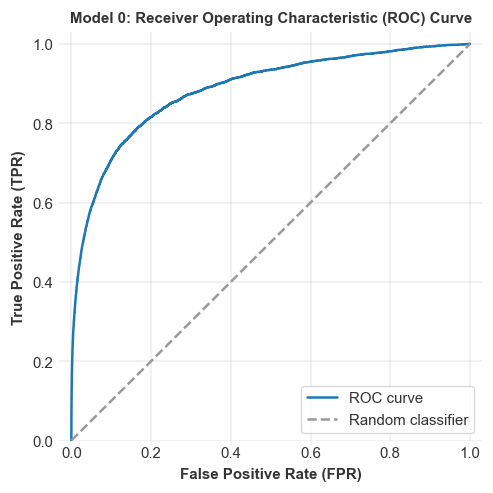

In [12]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

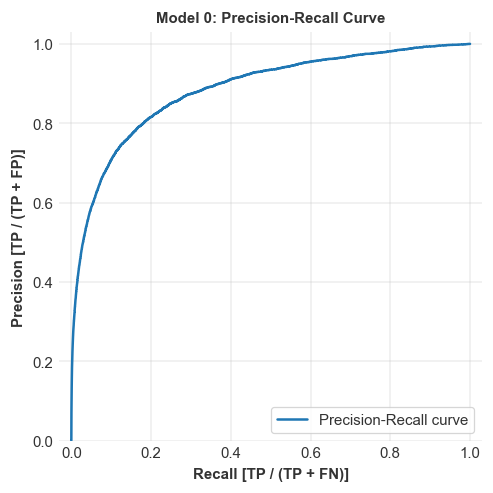

In [13]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

In [32]:

# -----------------------------
# Precision@K / Recall@K curves
# -----------------------------

def precision_recall_at_k(
    y_true: np.ndarray,
    y_score: np.ndarray,
    ks=(100, 500, 1000, 5000, 10000, 20000, 50000),
) -> pd.DataFrame:
    """
    Compute Precision@K and Recall@K for a binary classifier ranking.

    Parameters
    ----------
    y_true : array-like (n,)
        Binary labels {0,1}.
    y_score : array-like (n,)
        Model scores (higher = more likely positive).
    ks : iterable of int
        Cutoffs.

    Returns
    -------
    DataFrame with columns: K, tp, precision_at_k, recall_at_k.
    """
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score, dtype=float)

    if y_true.ndim != 1 or y_score.ndim != 1 or y_true.shape[0] != y_score.shape[0]:
        raise ValueError("y_true and y_score must be 1D arrays of the same length.")

    n = y_true.shape[0]
    pos_total = int(y_true.sum())
    if pos_total == 0:
        raise ValueError("y_true contains no positives; recall is undefined.")

    # sort descending by score
    order = np.argsort(-y_score, kind="mergesort")  # stable for ties
    y_sorted = y_true[order]

    # cumulative true positives along the ranked list
    ctp = np.cumsum(y_sorted)

    rows = []
    for K in ks:
        k = int(min(max(K, 1), n))
        tp = int(ctp[k - 1])
        precision = tp / k
        recall = tp / pos_total
        rows.append((k, tp, precision, recall))

    return pd.DataFrame(rows, columns=["K", "tp", "precision_at_k", "recall_at_k"])


def plot_precision_recall_at_k(pr_df: pd.DataFrame, title_prefix: str = "Validation"):
    """
    Plot Precision@K and Recall@K vs K (log-scaled x-axis).
    """
    ks = pr_df["K"].to_numpy()
    prec = pr_df["precision_at_k"].to_numpy()
    rec = pr_df["recall_at_k"].to_numpy()

    plt.figure(figsize=(9, 5))
    plt.plot(ks, prec, marker="o")
    plt.xscale("log")
    plt.xlabel("K (top-K flagged; log scale)")
    plt.ylabel("Precision@K")
    plt.title(f"{title_prefix}: Precision@K")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

    plt.figure(figsize=(9, 5))
    plt.plot(ks, rec, marker="o")
    plt.xscale("log")
    plt.xlabel("K (top-K flagged; log scale)")
    plt.ylabel("Recall@K")
    plt.title(f"{title_prefix}: Recall@K")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()



       K    tp  precision_at_k  recall_at_k
0    100    23         0.23000     0.004305
1    500   103         0.20600     0.019278
2   1000   178         0.17800     0.033315
3   5000   472         0.09440     0.088340
4  10000   707         0.07070     0.132323
5  20000  1008         0.05040     0.188658
6  50000  1466         0.02932     0.274378


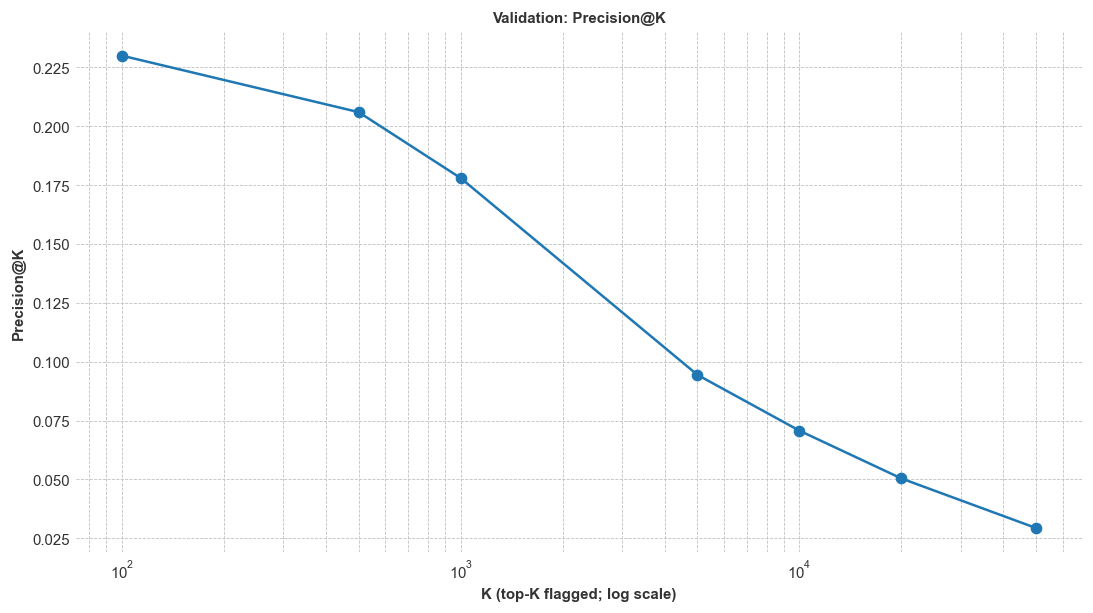

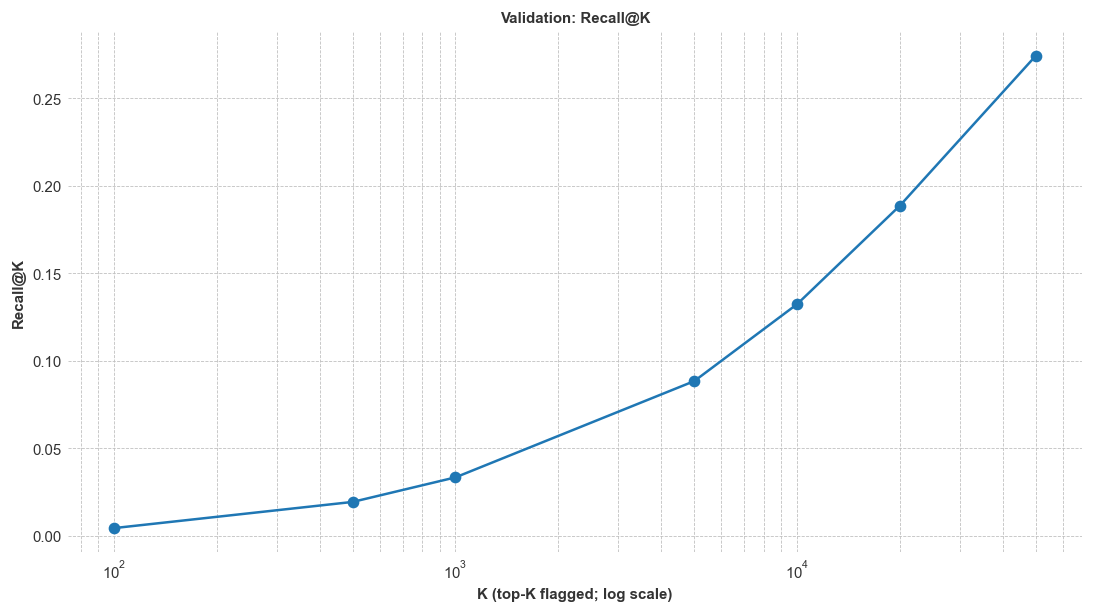

In [33]:
Ks = (100, 500, 1000, 5000, 10000, 20000, 50000)

pr_valid = precision_recall_at_k(y_valid.to_numpy(), p_valid, ks=Ks)
print(pr_valid)

plot_precision_recall_at_k(pr_valid, title_prefix="Validation")


#### Feature importance


In [14]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
21,ab_nicu,849438.017333
46,mage_c,508897.654339
43,dbwt,225832.855981
35,ca_disor,214363.997761
27,ca_cchd,154975.453822
45,bmi,114217.867037
44,wtgain,102781.178086
3,gestrec10,101806.840200
47,fagecomb,76822.707916
19,ab_aven1,76699.209155


### Evaluation subset for permutation importances and SHAP analysis


In [15]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

In [16]:
model_wrapped = ml_utils.LGBMEstimator(gbm)

In [17]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
35,ca_disor,1.240819e-02,0.000393
27,ca_cchd,1.067276e-02,0.000489
46,mage_c,1.009632e-02,0.000480
21,ab_nicu,4.090060e-03,0.000621
43,dbwt,3.426885e-03,0.000234
3,gestrec10,1.945598e-03,0.000322
16,dmeth_rec,1.563405e-03,0.000187
20,ab_aven6,9.308614e-04,0.000217
0,bfacil3,8.740559e-04,0.000215
36,meduc,8.289166e-04,0.000260


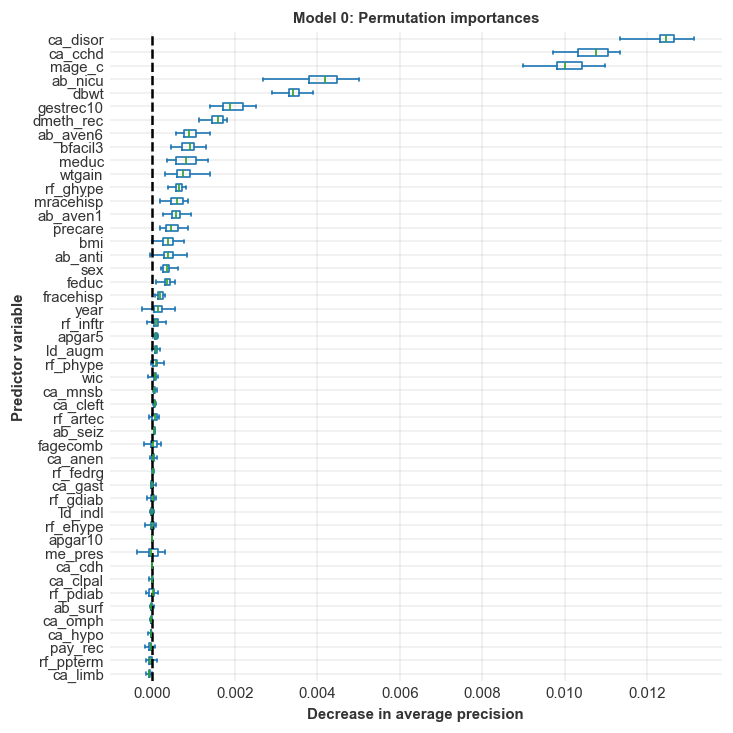

In [18]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

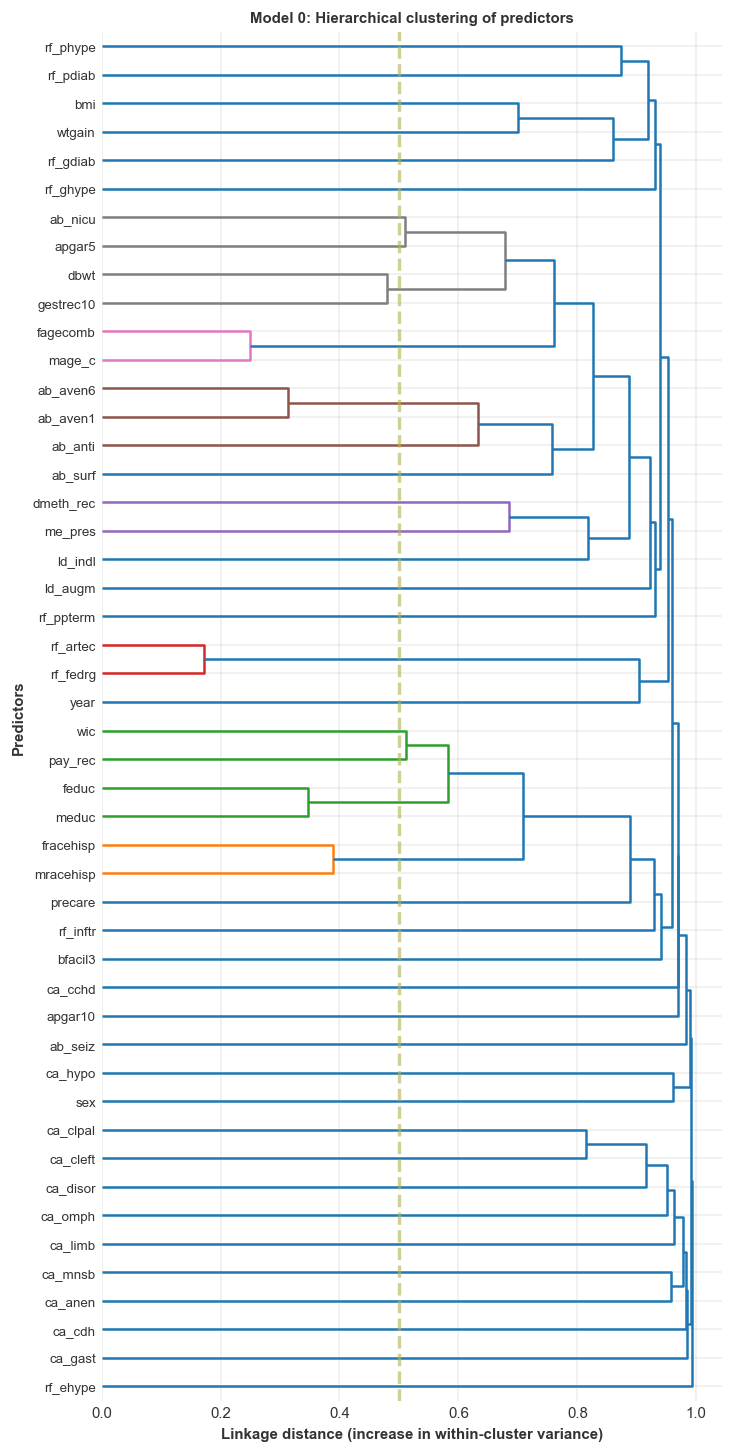

In [19]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

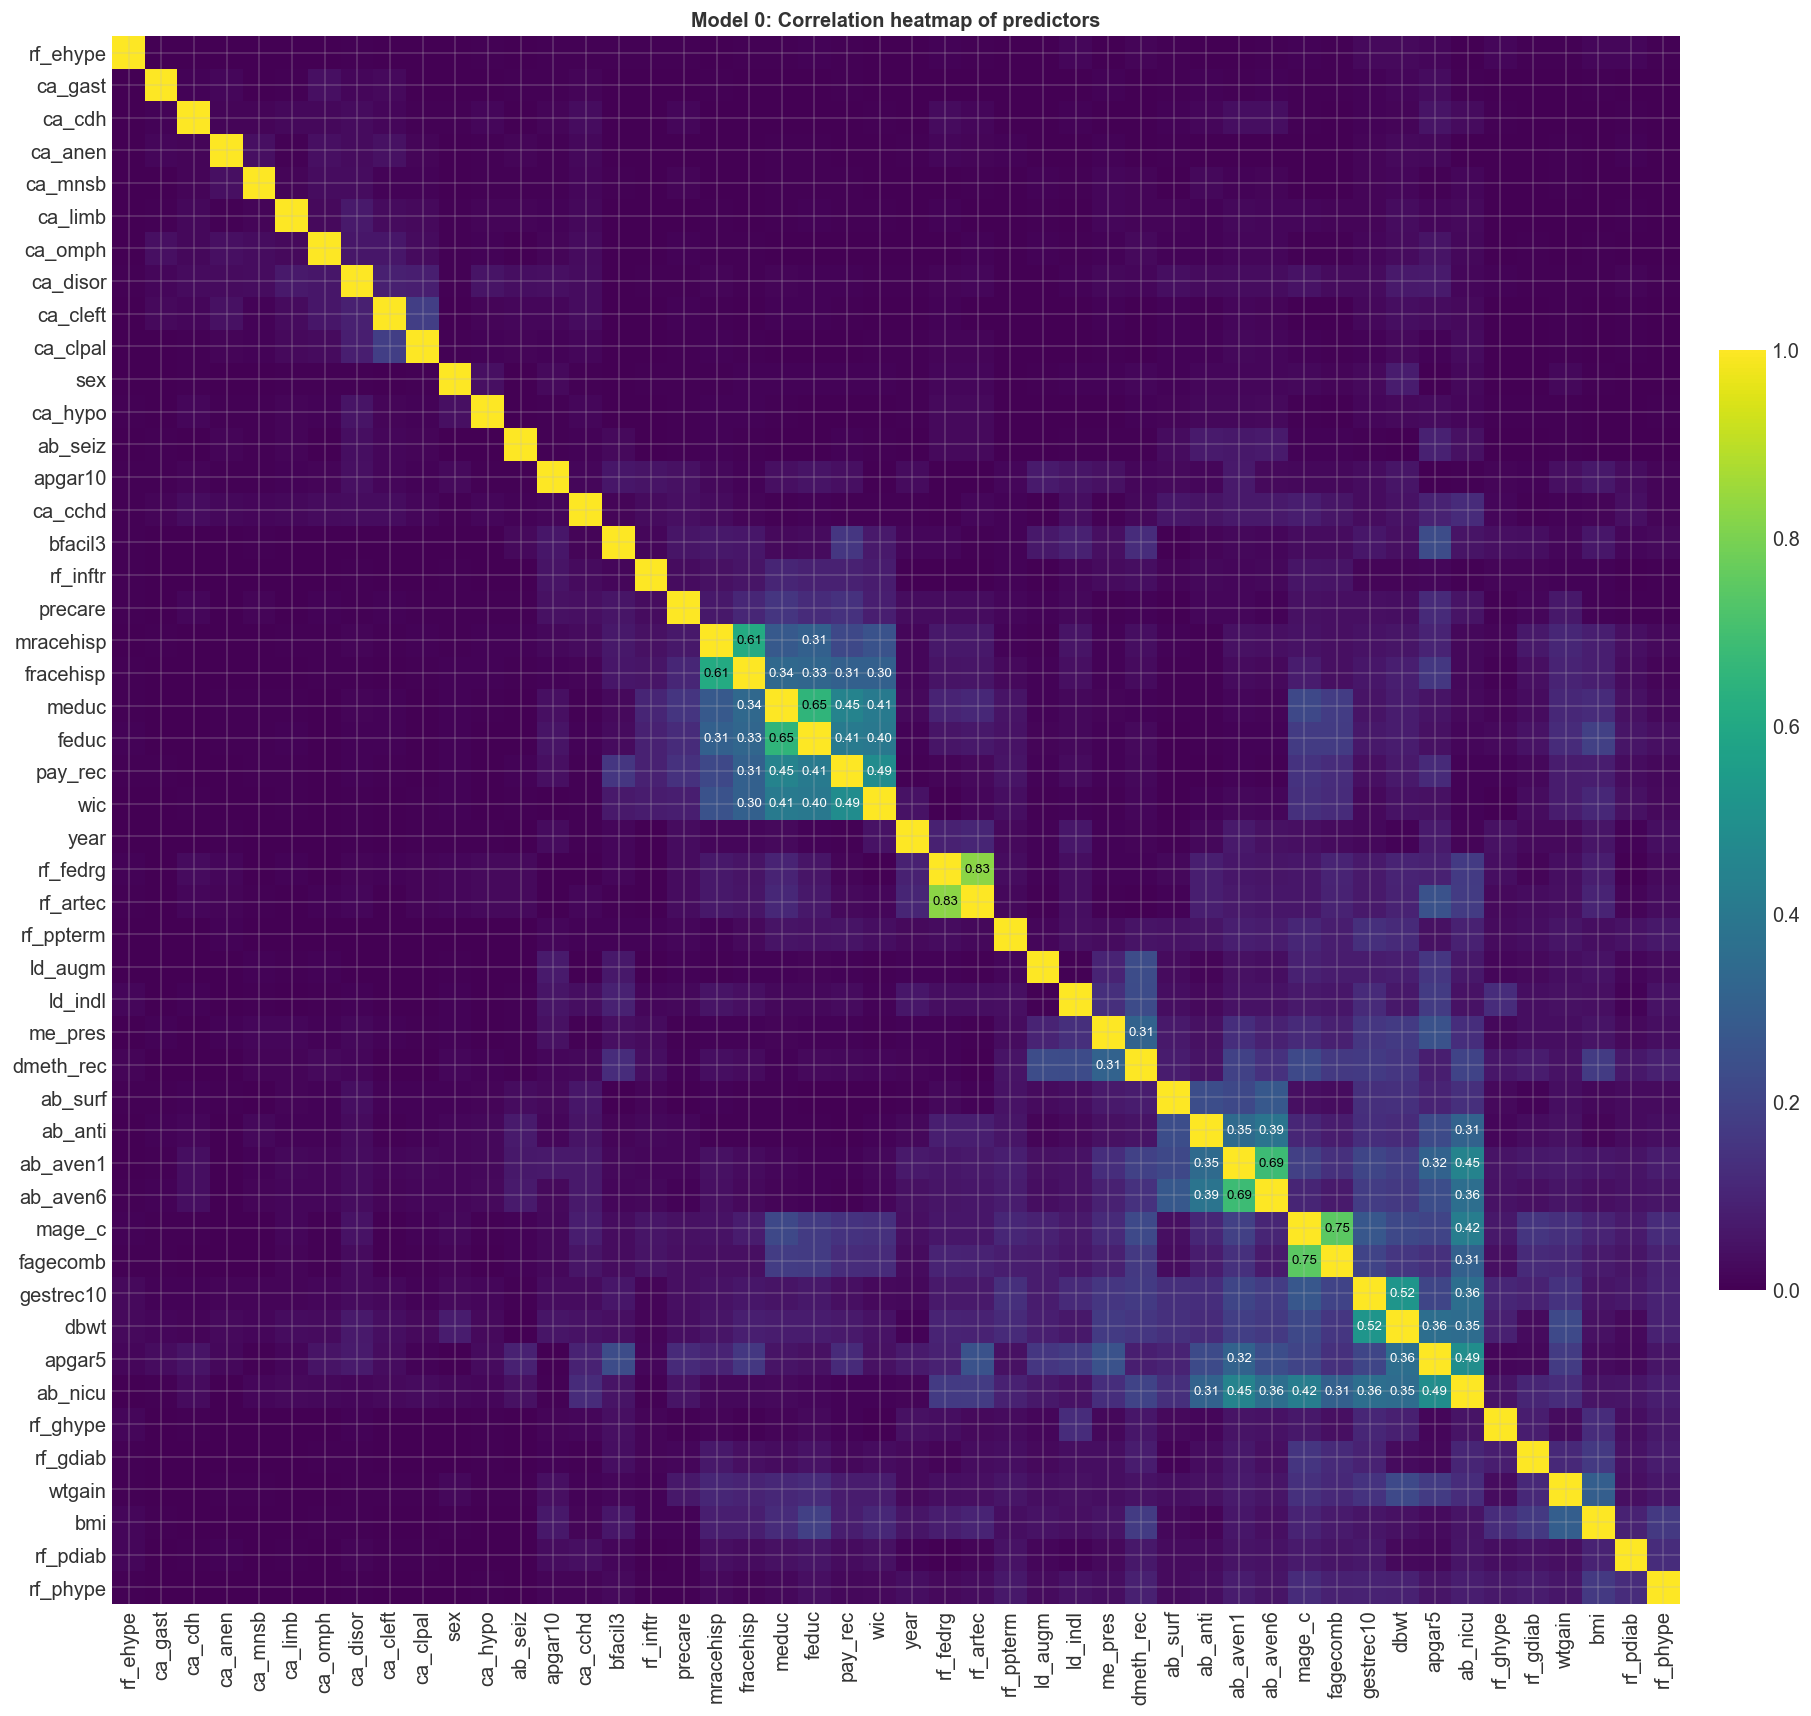

In [20]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [21]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clusterin

,feature,mean_abs_shap
21,ab_nicu,0.942680
46,mage_c,0.742983
43,dbwt,0.317597
3,gestrec10,0.284081
19,ab_aven1,0.187186
37,mracehisp,0.103886
27,ca_cchd,0.097939
44,wtgain,0.086658
35,ca_disor,0.085547
20,ab_aven6,0.062595


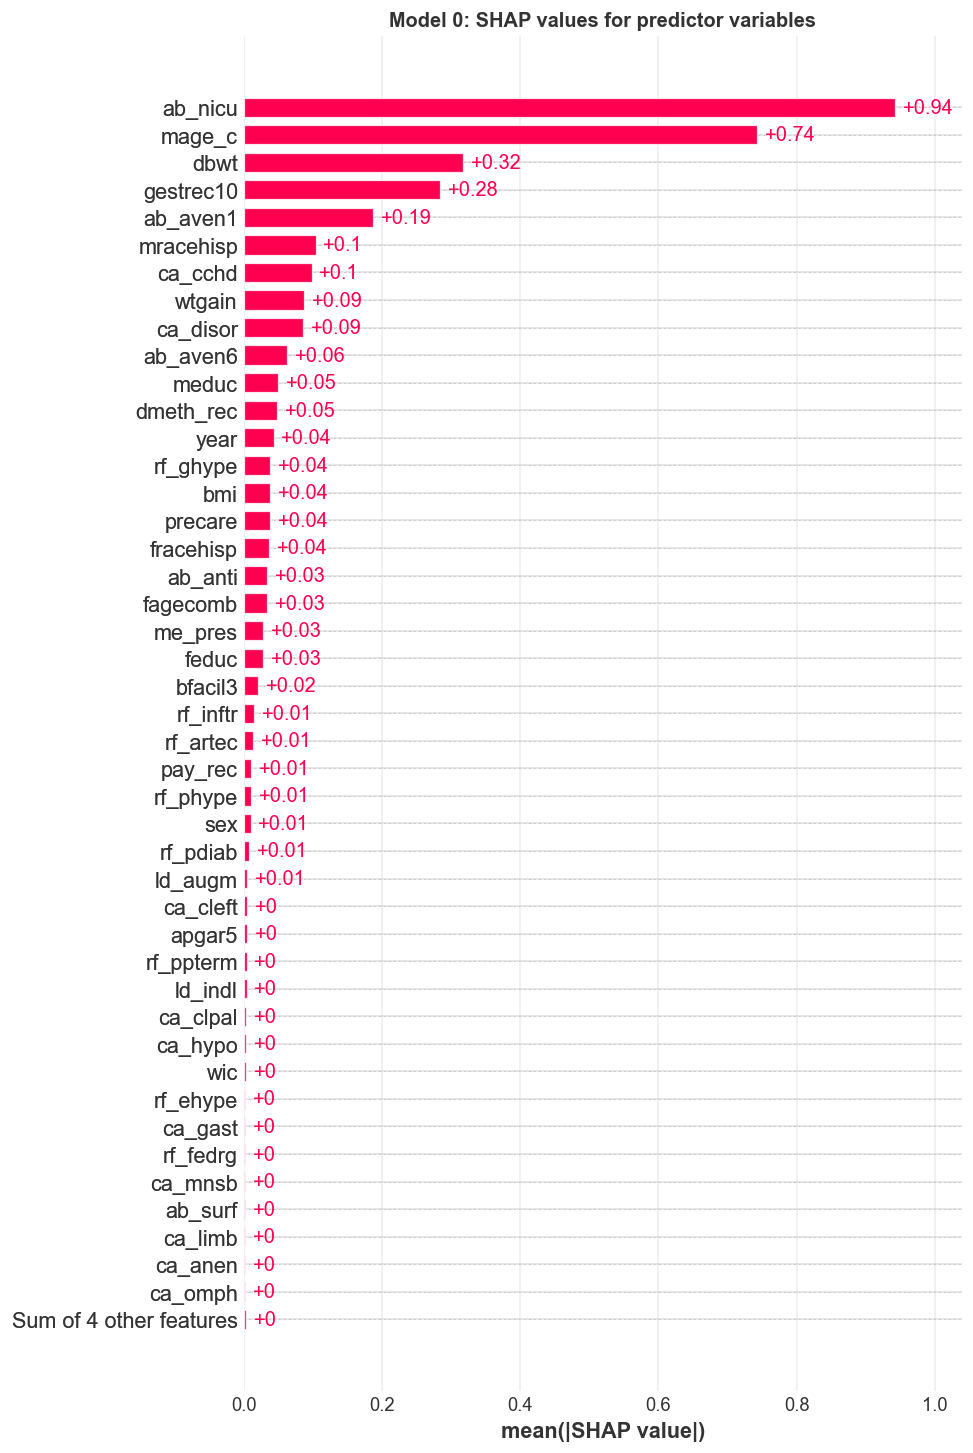

<Figure size 492x348 with 0 Axes>

In [22]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 12))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=45, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

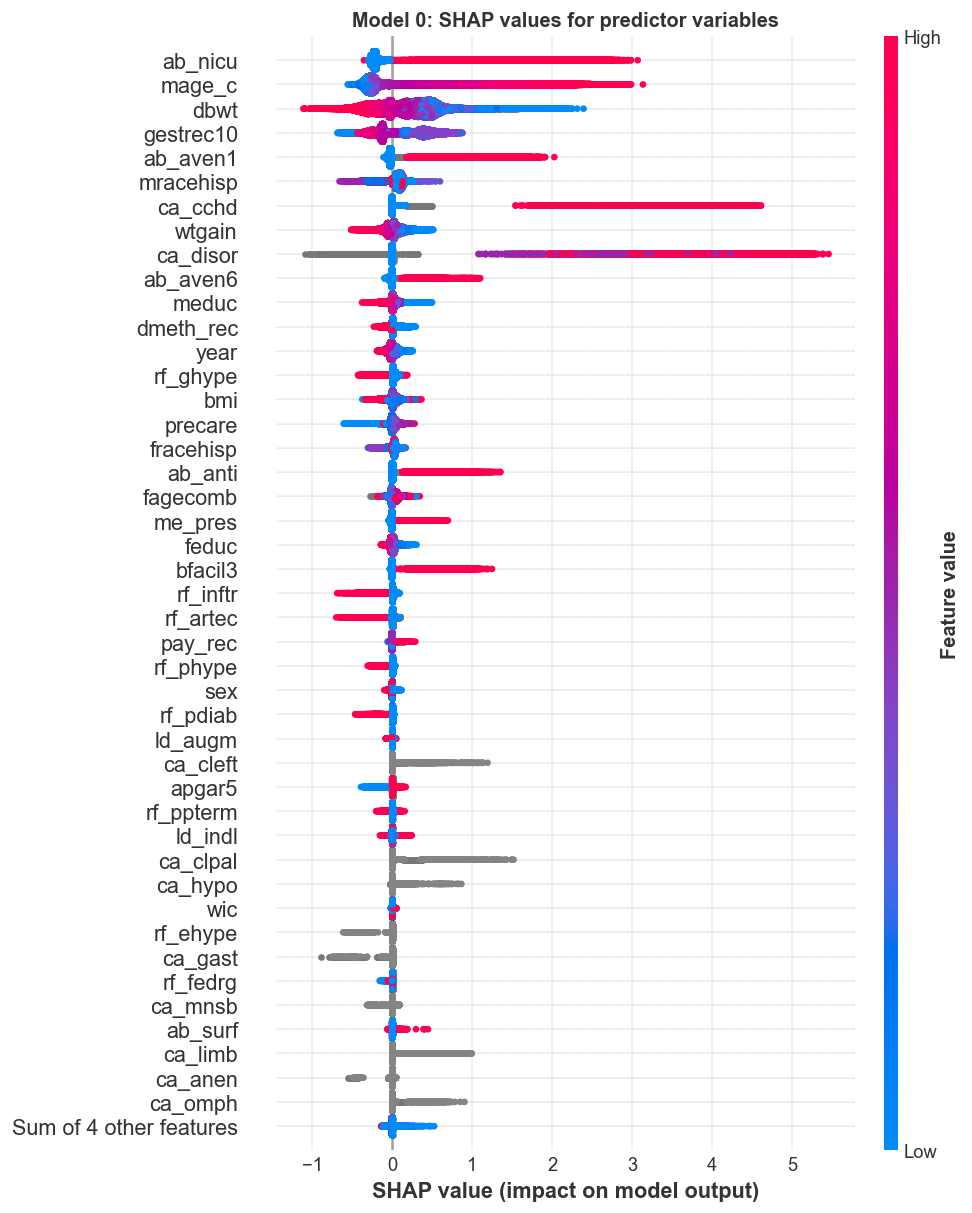

<Figure size 492x348 with 0 Axes>

In [23]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=45, plot_size=(8, 10))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

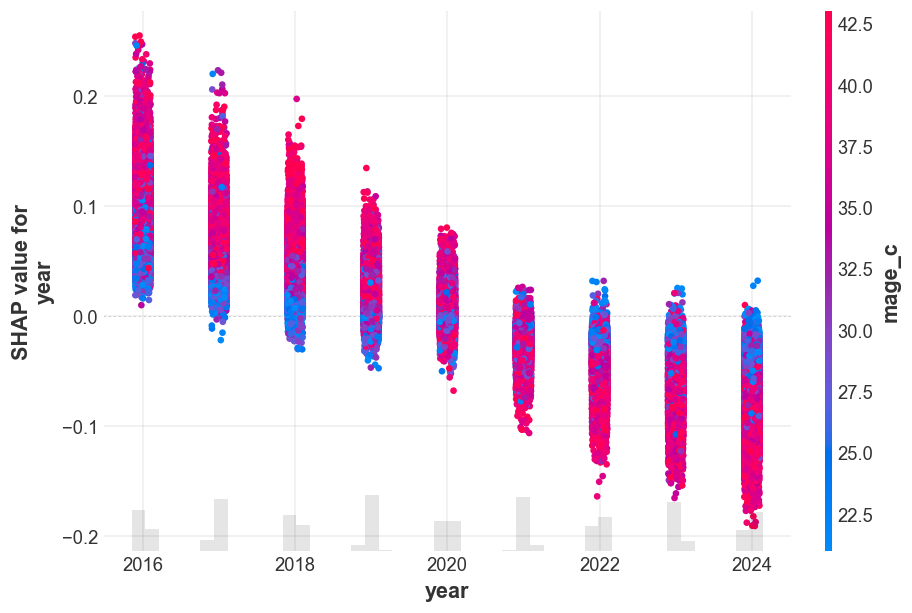

<Figure size 492x348 with 0 Axes>

In [24]:
ax = shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
# ax.set_title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 1


In [25]:
features_to_remove_0 = [
    "ca_cdh",
    "apgar10",
    "ca_cleft",
    "rf_artec",
    "ca_omph",
    "ca_clpal",
    "wic",
    "ca_limb"
]

X_train = X_train.drop(columns=features_to_remove_0)
X_valid = X_valid.drop(columns=features_to_remove_0)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_0]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 1
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_0)} predictors)"
)

print(f"Features removed: {features_to_remove_0}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

Features removed: ['ca_cdh', 'apgar10', 'ca_cleft', 'rf_artec', 'ca_omph', 'ca_clpal', 'wic', 'ca_limb']
Features remaining: ['bfacil3', 'sex', 'precare', 'gestrec10', 'rf_pdiab', 'rf_gdiab', 'rf_phype', 'rf_ghype', 'rf_ehype', 'rf_ppterm', 'rf_inftr', 'rf_fedrg', 'ld_indl', 'ld_augm', 'me_pres', 'dmeth_rec', 'apgar5', 'ab_aven1', 'ab_aven6', 'ab_nicu', 'ab_surf', 'ab_anti', 'ab_seiz', 'ca_anen', 'ca_mnsb', 'ca_cchd', 'ca_gast', 'ca_hypo', 'ca_disor', 'meduc', 'mracehisp', 'feduc', 'fracehisp', 'pay_rec', 'year', 'dbwt', 'wtgain', 'bmi', 'mage_c', 'fagecomb']
Number of features in Model 1 (after removing 8 predictors): 40


In [26]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 870
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	train's average_precision: 0.0313617	train's binary_logloss: 0.00415942	valid's average_precision: 0.0253337	valid's binary_logloss: 0.004188
[20]	train's average_precision: 0.0349119	train's binary_logloss: 0.00400974	valid's average_precision: 0.0263576	valid's binary_logloss: 0.00405577
[30]	train's average_precision: 0.0378214	train's binary_logloss: 0.00390924	valid's average_precision: 0.0270569	valid's binary_logloss: 0.00396917
[40]	train's average_precision: 0.04007	train's binary_logloss: 0.00383638	valid's average_precision: 0.0275179	valid's binary_logloss: 0.00390829
[50]	train

In [27]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [29]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds, tp, fp, n_pos = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.884320
1,Validation AP,0.030732
2,Validation log loss,0.003623
3,Precision at 10000,0.070700
4,Recall at 10000,0.132323
5,Precision (threshold=0.01),0.028490
6,Recall (threshold=0.01),0.276811


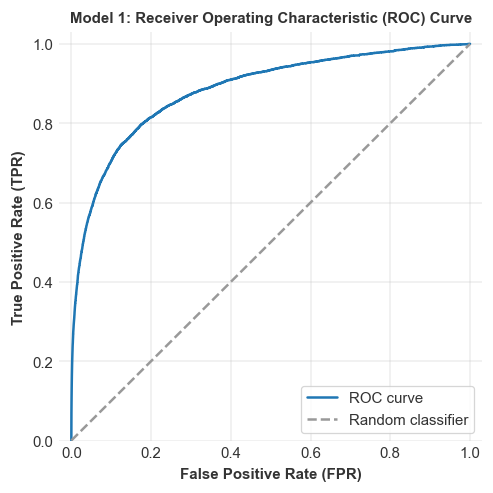

In [30]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

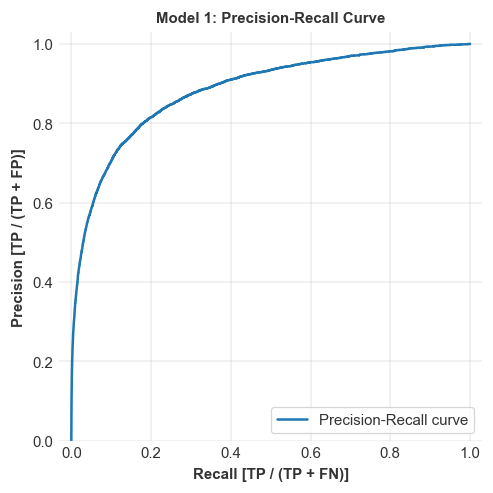

In [31]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

In [34]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
19,ab_nicu,880533.399693
38,mage_c,504635.253780
35,dbwt,224965.229931
28,ca_disor,219248.502513
25,ca_cchd,149566.538535
37,bmi,123433.371294
36,wtgain,108525.997284
3,gestrec10,101525.776969
39,fagecomb,79953.210130
17,ab_aven1,66516.015037


In [35]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [36]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
28,ca_disor,0.012229,0.000366
25,ca_cchd,0.010794,0.000443
38,mage_c,0.009764,0.000522
19,ab_nicu,0.004430,0.000455
35,dbwt,0.003146,0.000414
3,gestrec10,0.001767,0.000411
15,dmeth_rec,0.001635,0.000267
0,bfacil3,0.000944,0.000232
18,ab_aven6,0.000887,0.000145
29,meduc,0.000685,0.000258


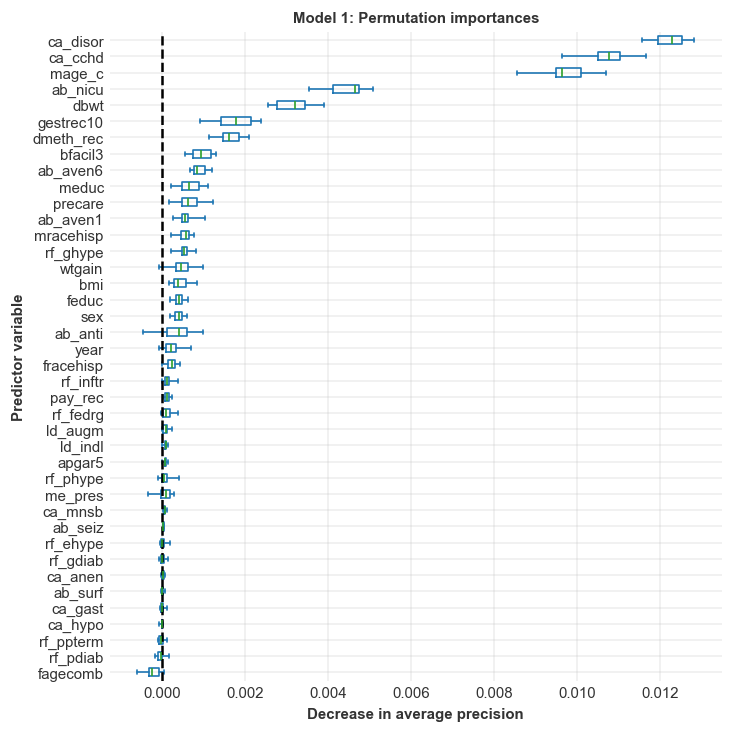

In [37]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

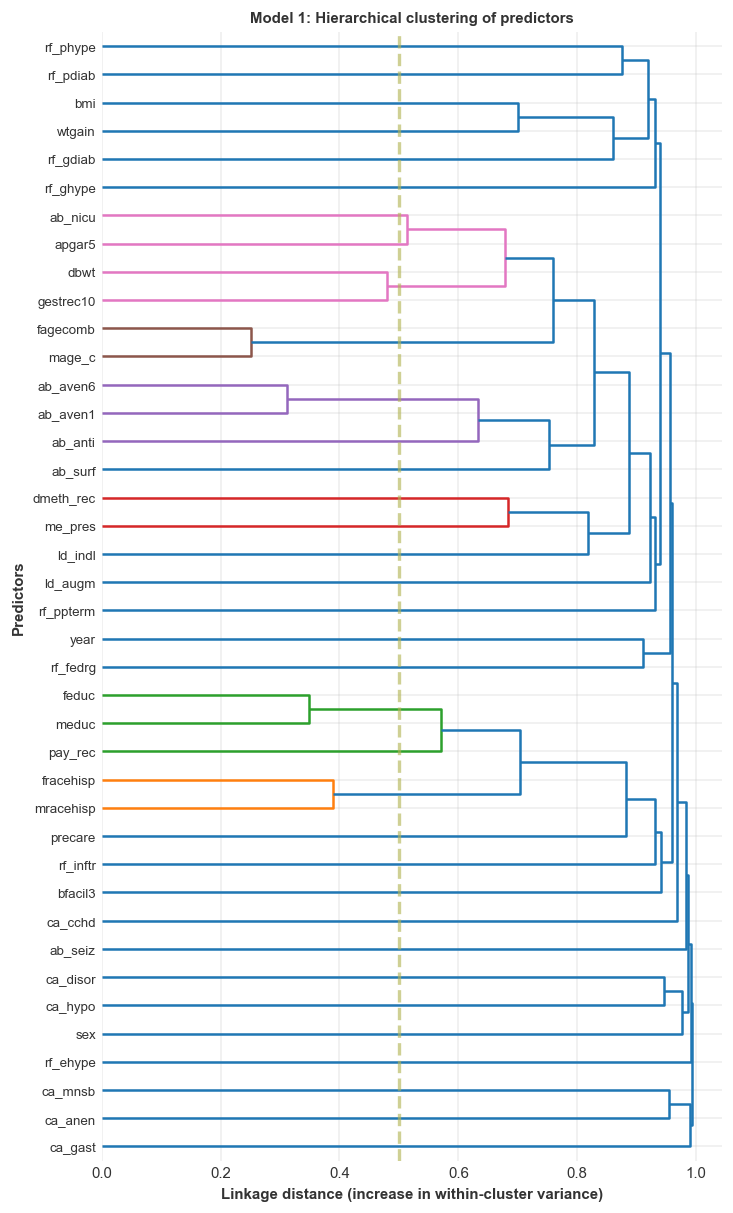

In [38]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

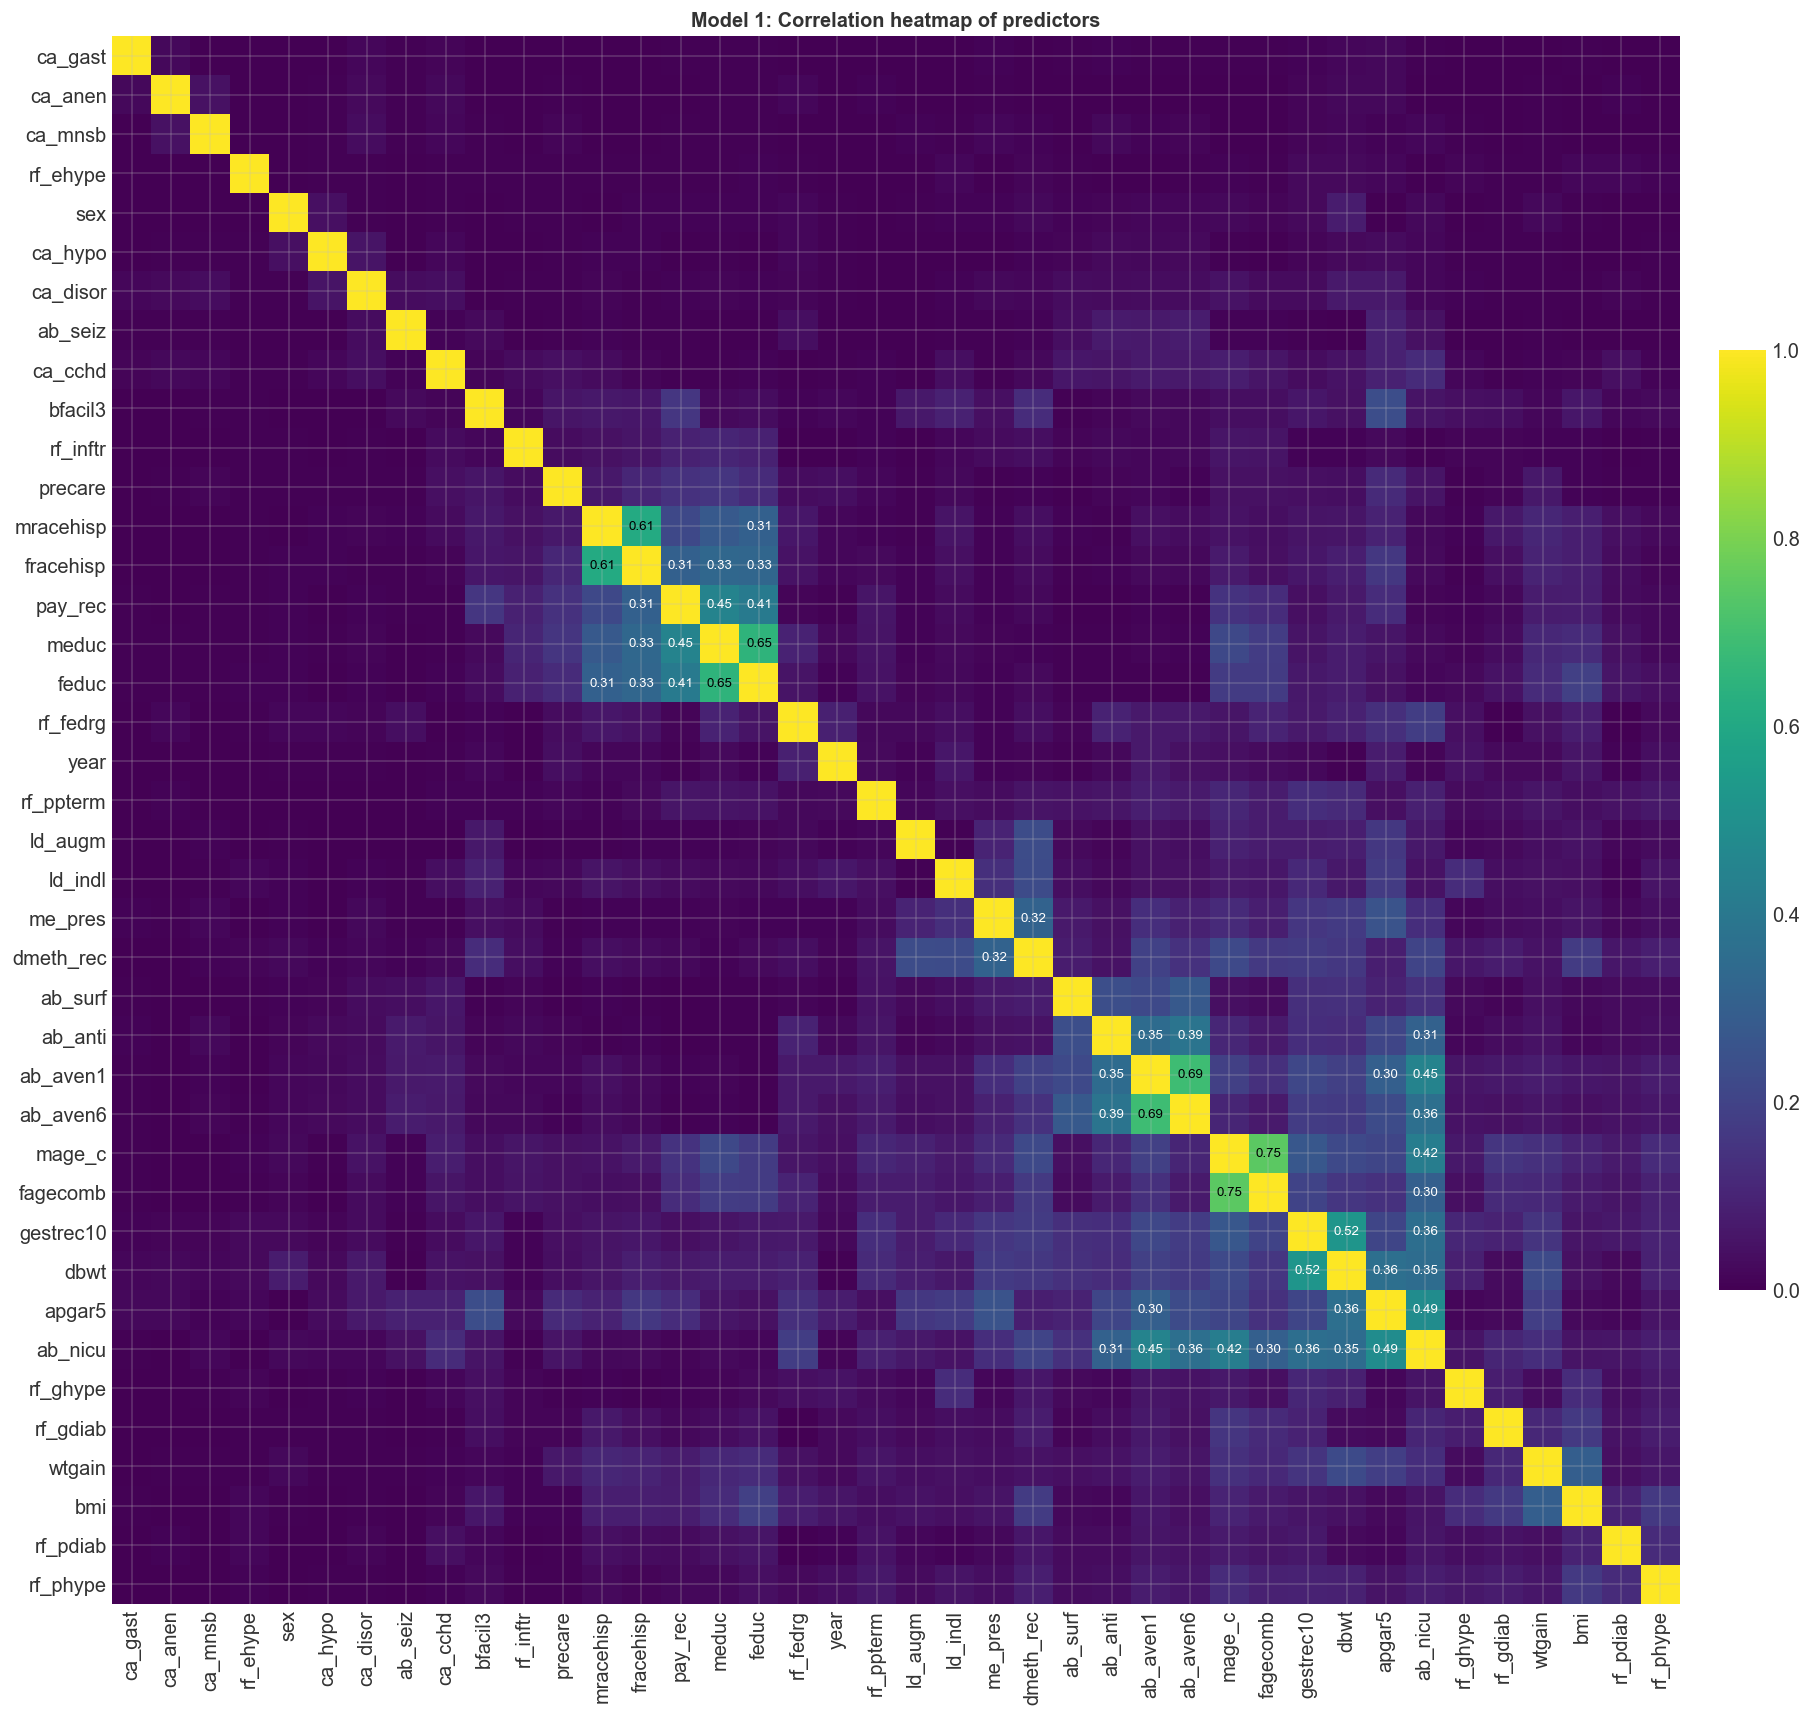

In [39]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [40]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clusterin

,feature,mean_abs_shap
19,ab_nicu,0.959076
38,mage_c,0.754475
35,dbwt,0.321774
3,gestrec10,0.286471
17,ab_aven1,0.184652
30,mracehisp,0.106503
25,ca_cchd,0.098534
36,wtgain,0.088552
28,ca_disor,0.088218
18,ab_aven6,0.062859


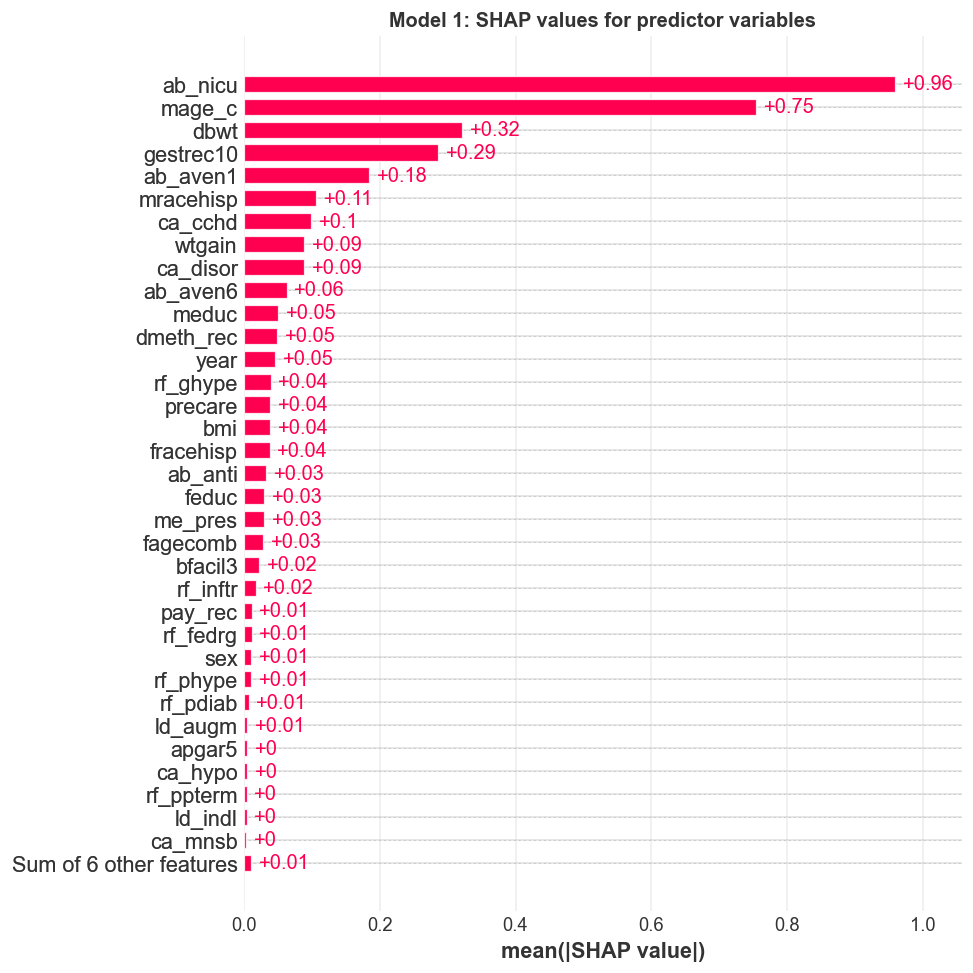

<Figure size 492x348 with 0 Axes>

In [41]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

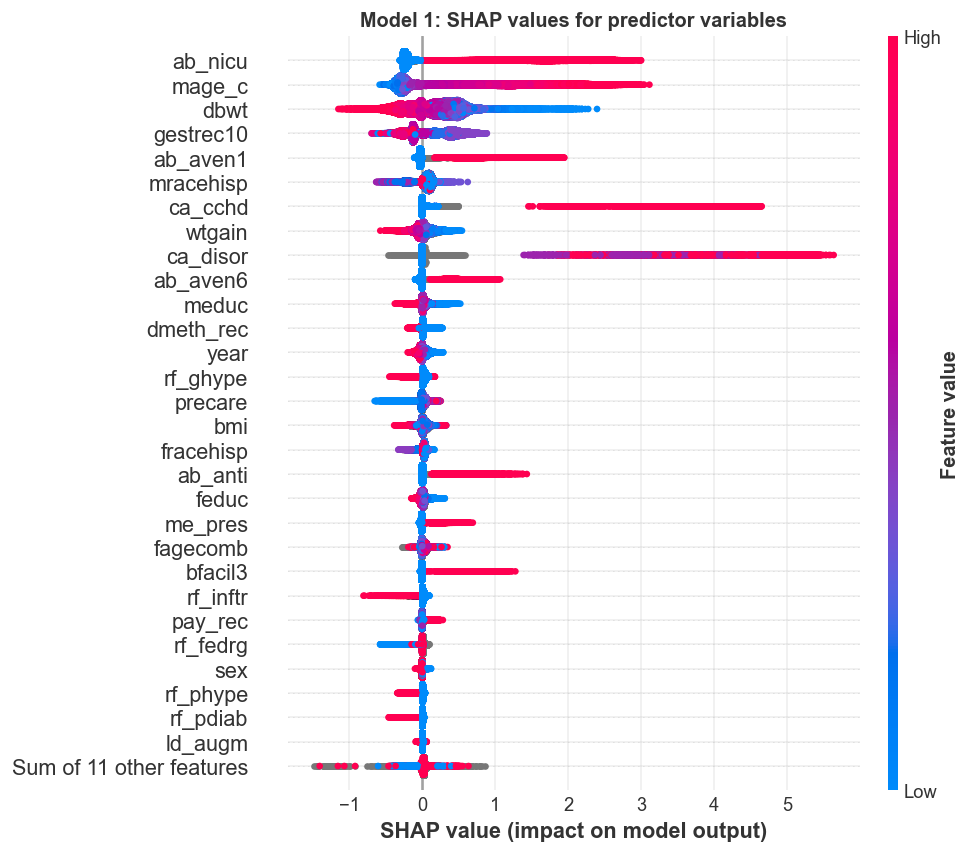

<Figure size 492x348 with 0 Axes>

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=40, plot_size=(8, 8))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

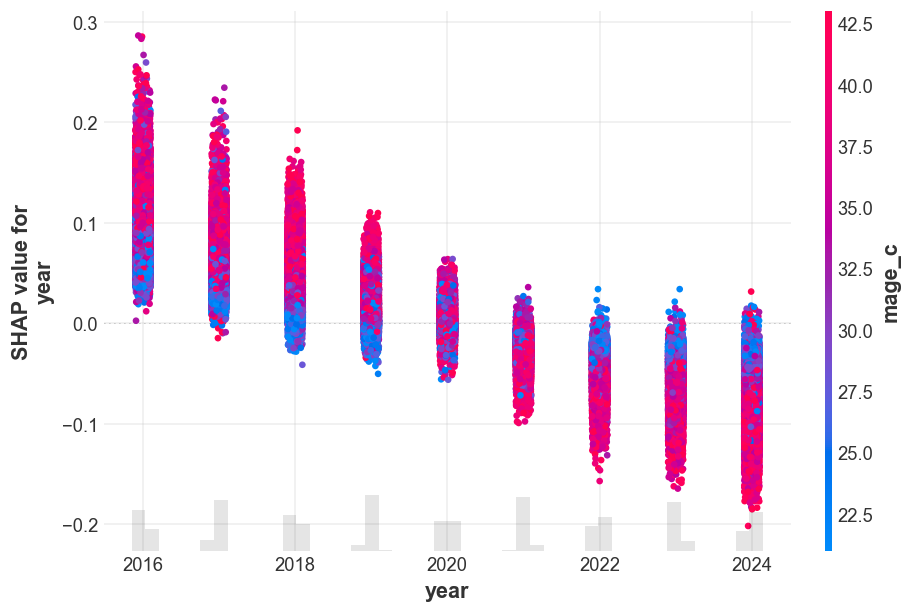

<Figure size 492x348 with 0 Axes>

In [43]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
#plt.title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 2


In [44]:
features_to_remove_1 = [
    "rf_pdiab",
    "ca_hypo",
    "rf_ppterm",
    "ca_mnsb",
    "rf_ehype",
    "ca_anen",
    "ca_gast",
    "ab_surf",
    "rf_gdiab",
    "ab_seiz",
]

X_train = X_train.drop(columns=features_to_remove_1)
X_valid = X_valid.drop(columns=features_to_remove_1)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_1]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 2
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_1)} predictors)"
)

print(f"Features removed: {features_to_remove_1}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

Features removed: ['rf_pdiab', 'ca_hypo', 'rf_ppterm', 'ca_mnsb', 'rf_ehype', 'ca_anen', 'ca_gast', 'ab_surf', 'rf_gdiab', 'ab_seiz']
Features remaining: ['bfacil3', 'sex', 'precare', 'gestrec10', 'rf_phype', 'rf_ghype', 'rf_inftr', 'rf_fedrg', 'ld_indl', 'ld_augm', 'me_pres', 'dmeth_rec', 'apgar5', 'ab_aven1', 'ab_aven6', 'ab_nicu', 'ab_anti', 'ca_cchd', 'ca_disor', 'meduc', 'mracehisp', 'feduc', 'fracehisp', 'pay_rec', 'year', 'dbwt', 'wtgain', 'bmi', 'mage_c', 'fagecomb']
Number of features in Model 2 (after removing 10 predictors): 30


In [45]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 12466, number of negative: 23499993
[LightGBM] [Info] Total Bins 840
[LightGBM] [Info] Number of data points in the train set: 23512459, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541750
[LightGBM] [Info] Start training from score -7.541750
Training until validation scores don't improve for 50 rounds
[10]	train's average_precision: 0.0309258	train's binary_logloss: 0.00415468	valid's average_precision: 0.0251931	valid's binary_logloss: 0.00418331
[20]	train's average_precision: 0.0348086	train's binary_logloss: 0.00401327	valid's average_precision: 0.0266391	valid's binary_logloss: 0.00405839
[30]	train's average_precision: 0.0375188	train's binary_logloss: 0.00391219	valid's average_precision: 0.0273223	valid's binary_logloss: 0.00397111
[40]	train's average_precision: 0.039545	train's binary_logloss: 0.00383857	valid's average_precision: 0.0277497	valid's binary_logloss: 0.00390929
[50]	tr

In [46]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [47]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds, tp, fp, n_pos = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.885064
1,Validation AP,0.030862
2,Validation log loss,0.003623
3,Precision at 10000,0.069700
4,Recall at 10000,0.130451
5,Precision (threshold=0.01),0.027364
6,Recall (threshold=0.01),0.276998


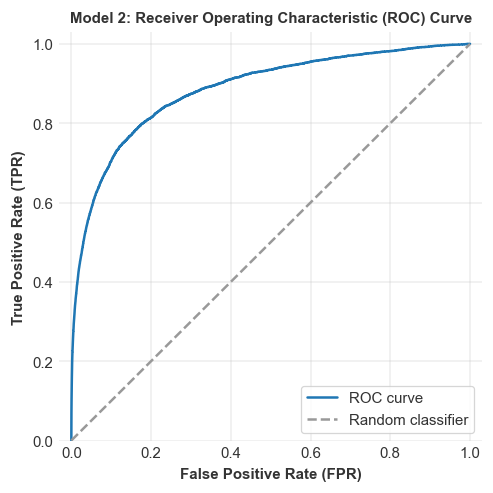

In [48]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

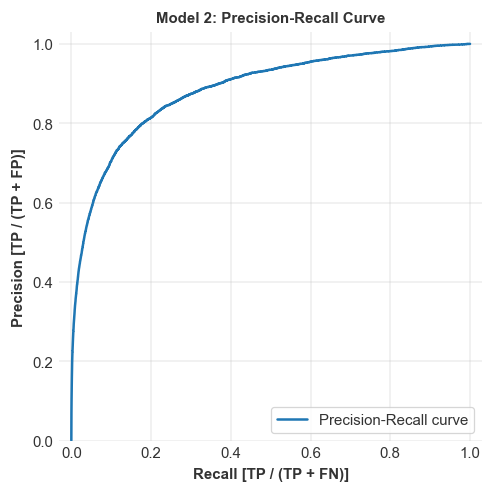

In [49]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

       K    tp  precision_at_k  recall_at_k
0    100    28         0.28000     0.005241
1    500   106         0.21200     0.019839
2   1000   168         0.16800     0.031443
3   5000   475         0.09500     0.088901
4  10000   697         0.06970     0.130451
5  20000  1015         0.05075     0.189968
6  50000  1451         0.02902     0.271570


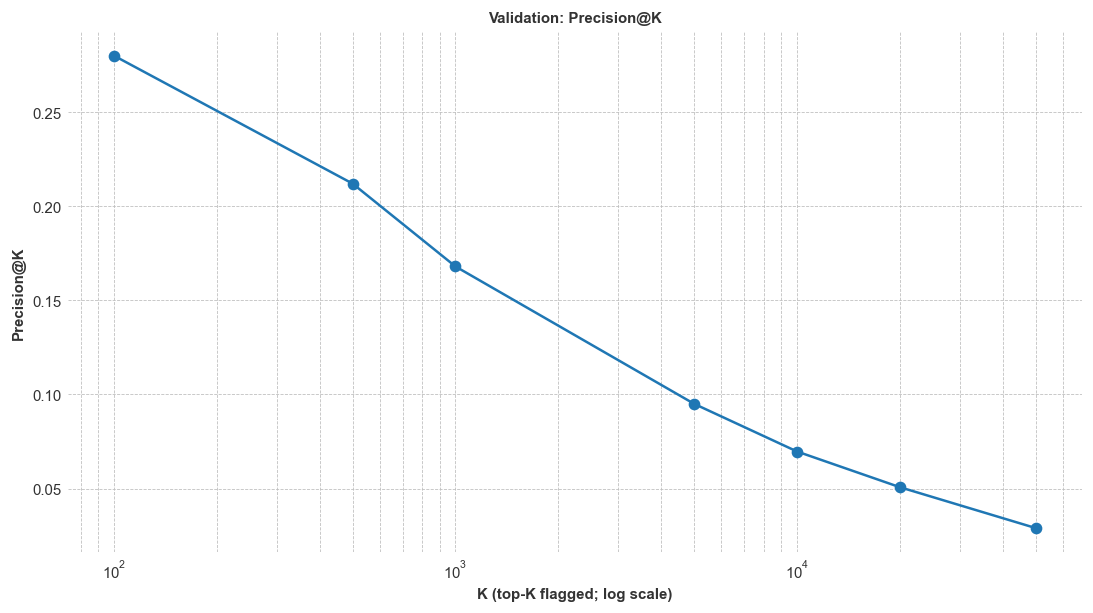

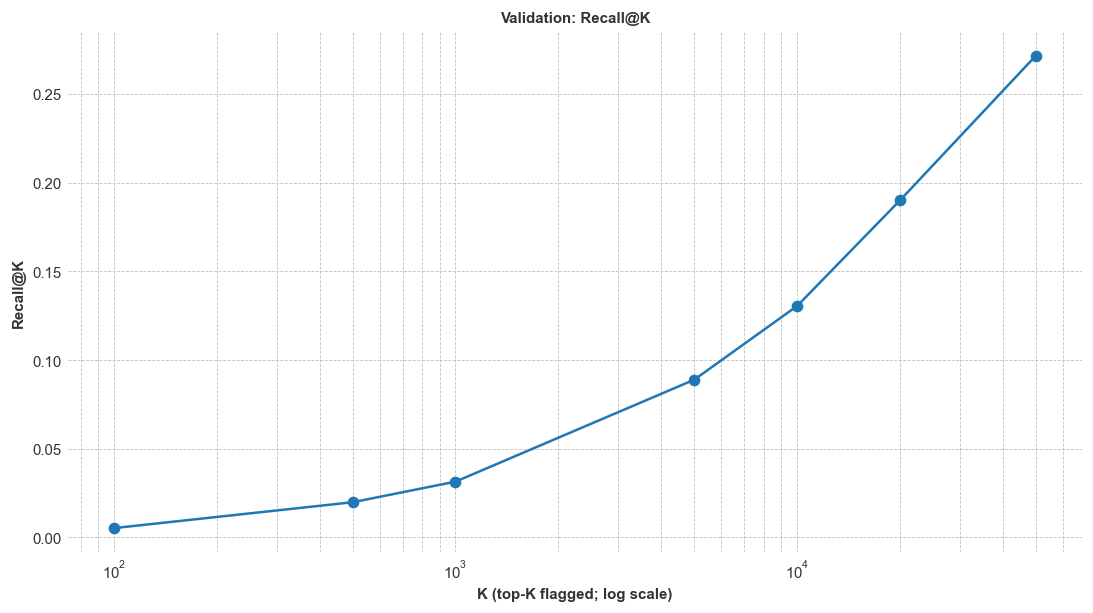

In [50]:

pr_valid = precision_recall_at_k(y_valid.to_numpy(), p_valid, ks=Ks)
print(pr_valid)

plot_precision_recall_at_k(pr_valid, title_prefix="Validation")


In [51]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
15,ab_nicu,898592.532990
28,mage_c,501538.481565
25,dbwt,254243.216582
18,ca_disor,218805.329412
17,ca_cchd,163619.109642
27,bmi,151444.786056
26,wtgain,128512.584530
29,fagecomb,106510.533540
3,gestrec10,103604.423243
13,ab_aven1,56258.032947


In [52]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [53]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
18,ca_disor,0.012370,0.000309
17,ca_cchd,0.011233,0.000472
28,mage_c,0.010202,0.000369
15,ab_nicu,0.004488,0.000616
25,dbwt,0.003243,0.000417
3,gestrec10,0.002021,0.000438
11,dmeth_rec,0.001878,0.000389
0,bfacil3,0.001003,0.000329
14,ab_aven6,0.000900,0.000209
19,meduc,0.000867,0.000208


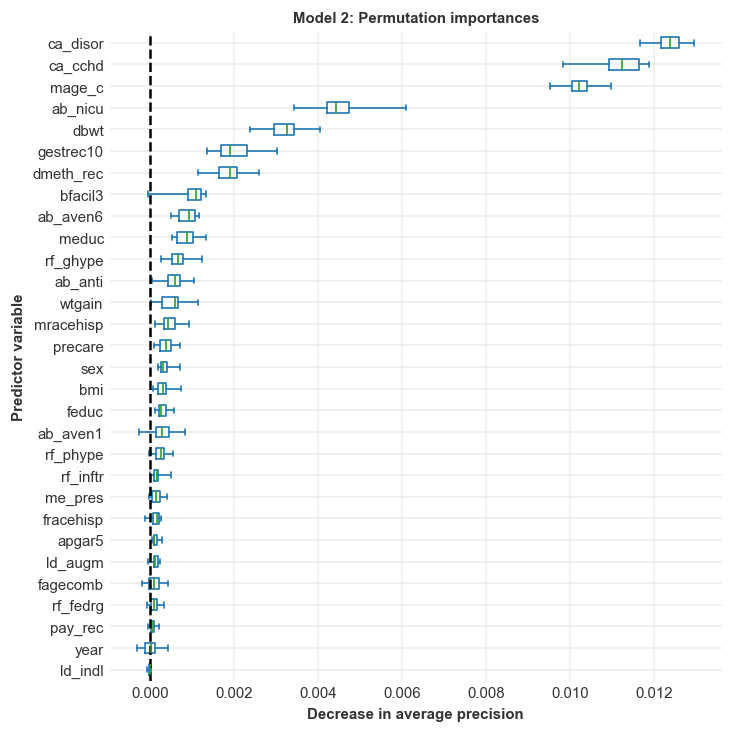

In [54]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

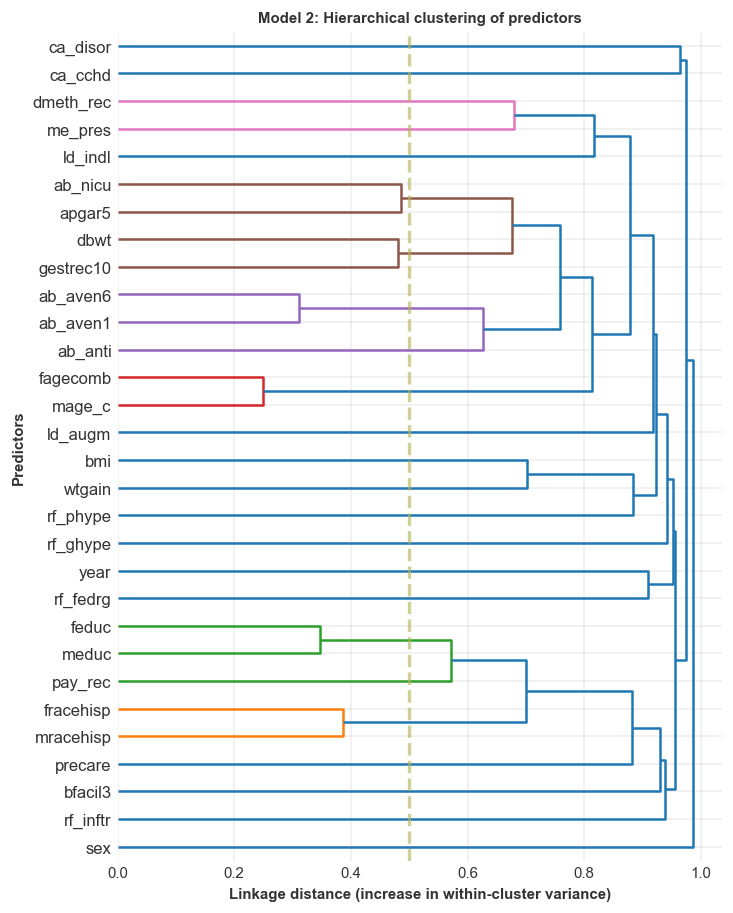

In [55]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

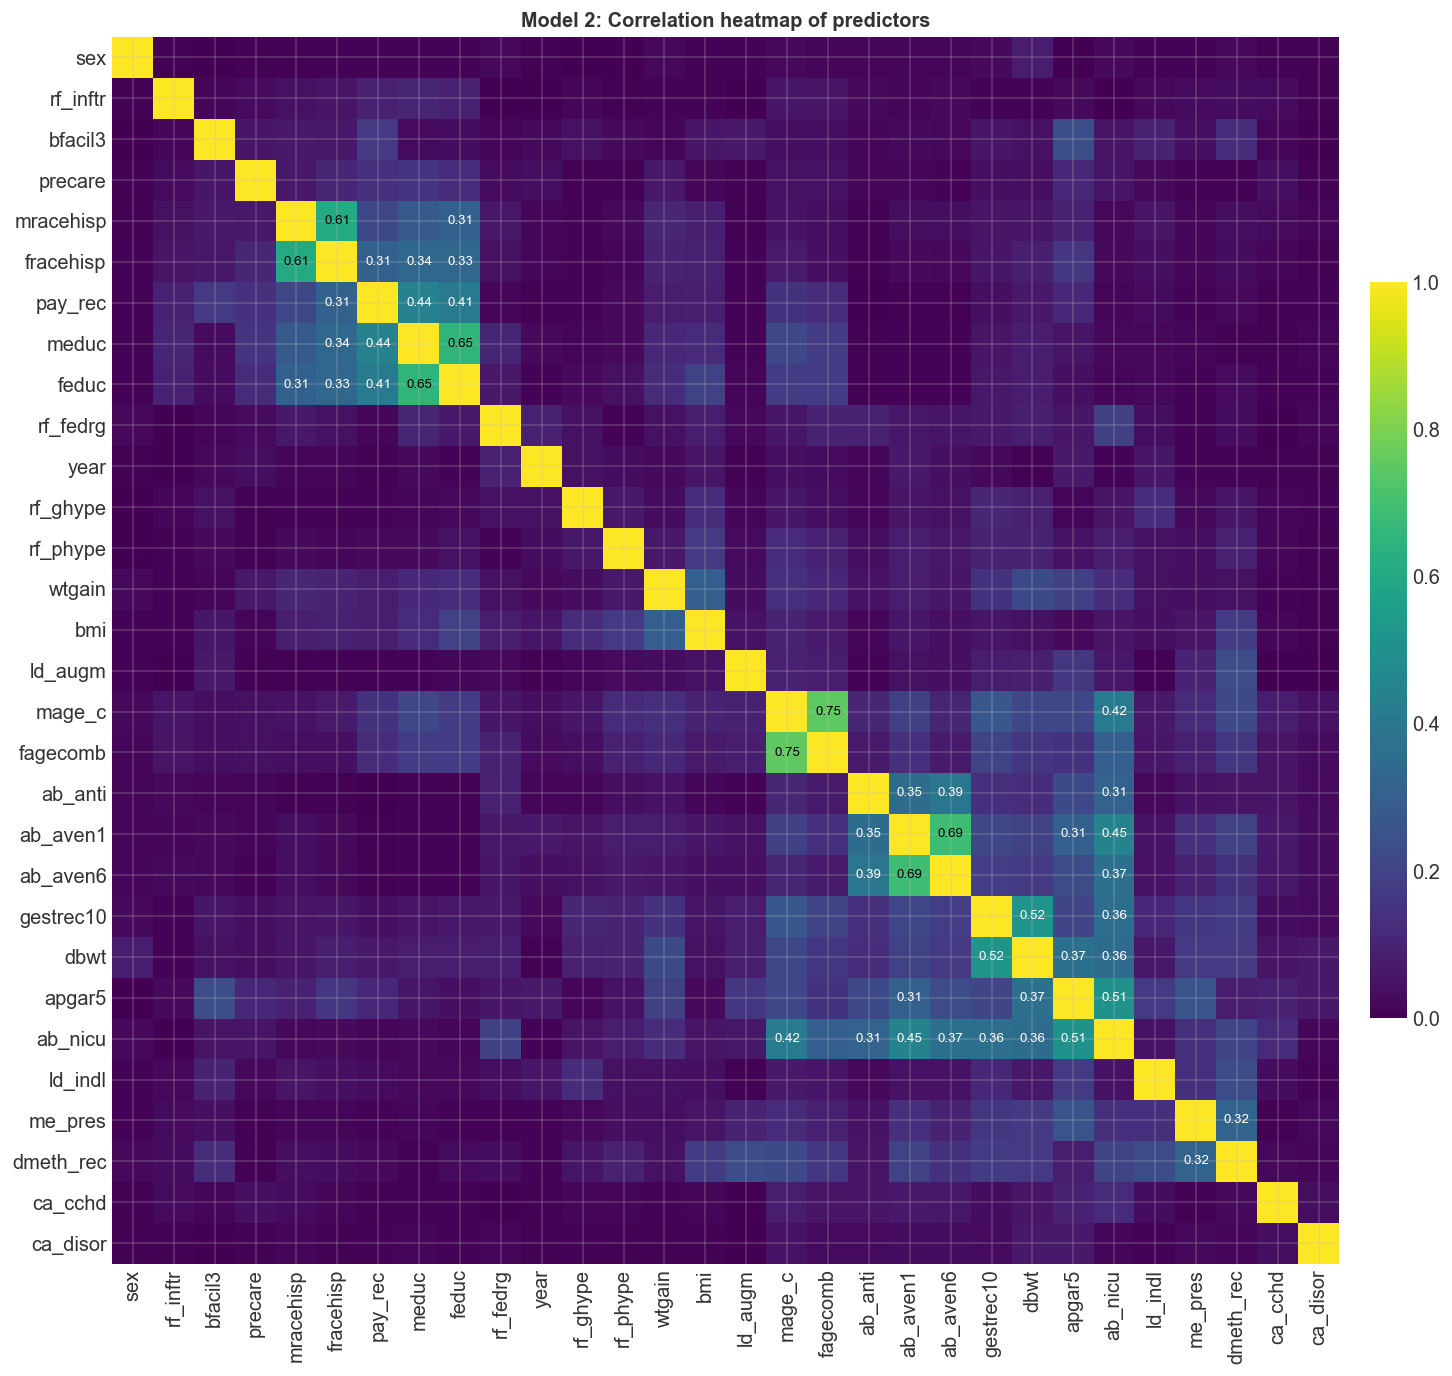

In [56]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [57]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clusterin

,feature,mean_abs_shap
15,ab_nicu,0.969358
28,mage_c,0.767564
25,dbwt,0.344658
3,gestrec10,0.302586
13,ab_aven1,0.191672
20,mracehisp,0.115242
17,ca_cchd,0.104027
26,wtgain,0.091984
18,ca_disor,0.090313
14,ab_aven6,0.065836


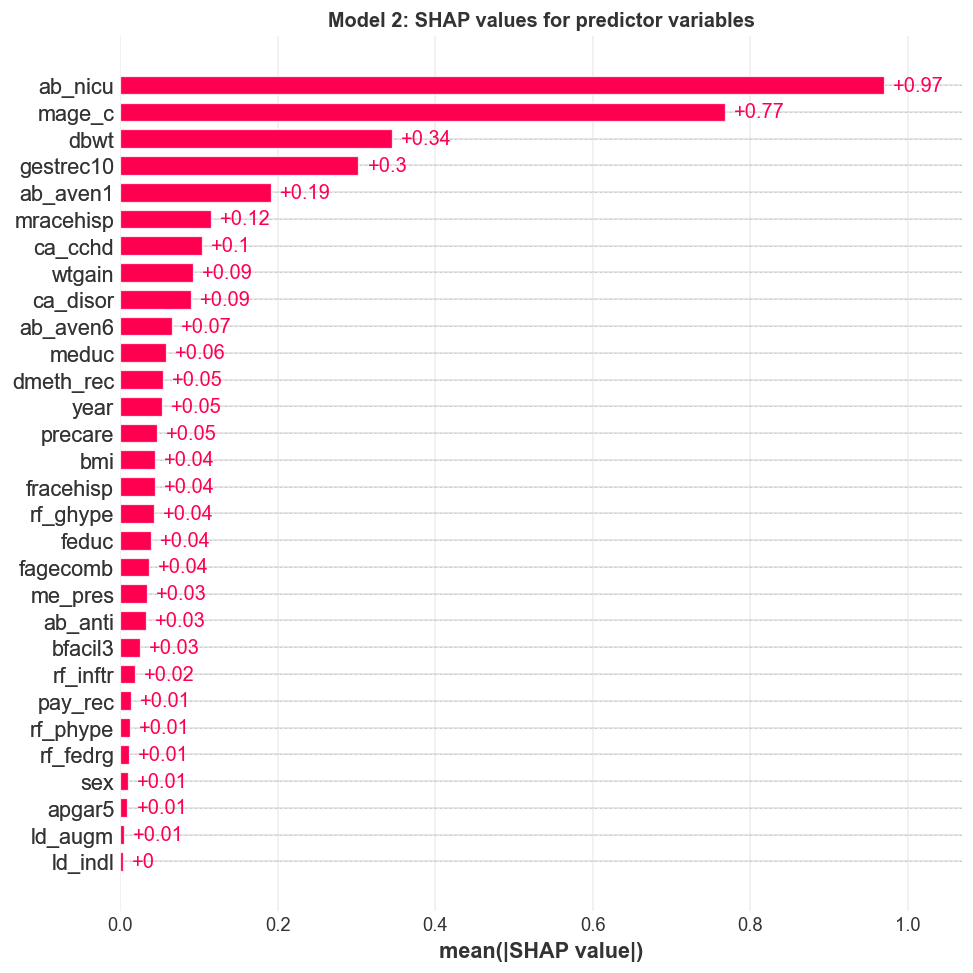

<Figure size 492x348 with 0 Axes>

In [58]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

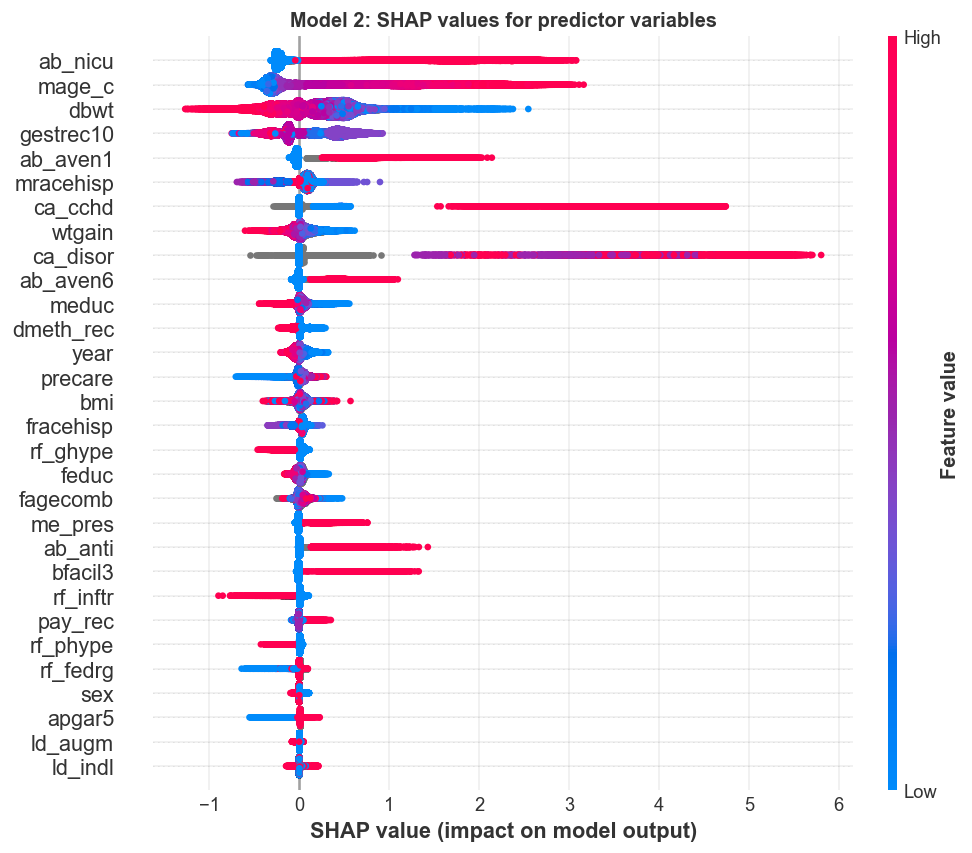

<Figure size 492x348 with 0 Axes>

In [59]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

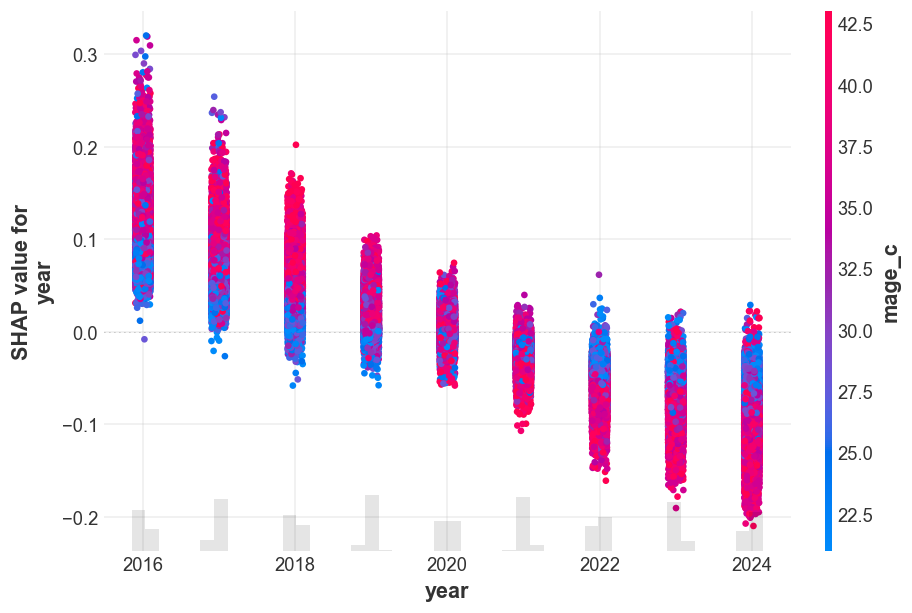

<Figure size 492x348 with 0 Axes>

In [60]:
ax = shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

In [ ]:
# More SHAP plots...

## Prediction


In [61]:
p_valid = gbm.predict(X_valid, num_iteration=gbm.best_iteration, raw_score=False)

print("best_iteration:", gbm.best_iteration)
print("mean raw prob:", float(p_valid.mean()))


print("Raw logloss:", log_loss(y_valid, p_valid, labels=[0, 1]))
print("Raw brier:  ", brier_score_loss(y_valid, p_valid))

best_iteration: 480
mean raw prob: 0.000526899900150652
Raw logloss: 0.0036227100484713154
Raw brier:   0.0005211341203788482


In [62]:
def tail_calibration_table(y, p, fracs=(1e-2, 1e-3, 1e-4, 1e-5)):
    """
    Compare predicted vs observed event rates in the top fracs of scores.

    Parameters
    ----------
    y : array-like (0/1)
    p : array-like (probabilities)
    fracs : iterable of floats
        Fractions like 1e-3 for top 0.1%.

    Returns
    -------
    DataFrame with k, predicted mean, observed rate, and counts.
    """
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)

    order = np.argsort(-p)
    y_sorted = y[order]
    p_sorted = p[order]

    N = len(y)
    rows = []
    for f in fracs:
        k = max(1, int(round(N * f)))
        y_top = y_sorted[:k]
        p_top = p_sorted[:k]

        obs_rate = y_top.mean()
        pred_rate = p_top.mean()

        tp = int(y_top.sum())
        fp = int(k - tp)

        rows.append(
            {
                "top_frac": f,
                "k": k,
                "pred_rate_mean": pred_rate,
                "obs_rate": obs_rate,
                "tp": tp,
                "fp": fp,
                "pred_minus_obs": pred_rate - obs_rate,
                "ratio_pred_to_obs": (pred_rate / obs_rate) if obs_rate > 0 else np.nan,
            }
        )

    return pd.DataFrame(rows)

In [63]:
fracs = (1e-2, 1e-3, 1e-4, 1e-5)  # 1%, 0.1%, 0.01%, 0.001%

calibration_table = tail_calibration_table(y_valid, p_valid, fracs=fracs)

calibration_table["model"] = "raw"

calibration_table.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_tail_calibration_table.csv",
    index=False,
)

calibration_table

,top_frac,k,pred_rate_mean,obs_rate,tp,fp,pred_minus_obs,ratio_pred_to_obs,model
0,0.01000,100768,0.018241,0.018329,1847,98921,-0.000088,0.995208,raw
1,0.00100,10077,0.072519,0.069564,701,9376,0.002955,1.042476,raw
2,0.00010,1008,0.199108,0.168651,170,838,0.030457,1.180594,raw
3,0.00001,101,0.341959,0.287129,29,72,0.054830,1.190959,raw


In [64]:
gbm.save_model(
    f"{OUTPUT_DIR}/final_model_{model_idx}.txt",
    num_iteration=best_iter,
)

In [65]:
X_full = df[features]

categorical = [col for col in categorical if col in X_full.columns]

X_full[categorical] = X_full[categorical].astype("category")

In [66]:
p_full = gbm.predict(X_full, num_iteration=gbm.best_iteration)  # P(S=1|X)

In [67]:
df["p_ds_lb_pred_01"] = p_full

In [68]:
df[["year", "p_ds_lb_pred_01", "ca_down_c_p_n"]].groupby(
    "year"
).sum().reset_index()

,year,p_ds_lb_pred_01,ca_down_c_p_n
0,2016,2088.671828,2168
1,2017,2018.934672,2044
2,2018,2024.182589,2108
3,2019,2002.051046,2030
4,2020,1937.895350,1954
5,2021,1940.361850,1903
6,2022,1896.075519,1861
7,2023,1905.005407,1855
8,2024,1917.470720,1886


In [69]:
import duckdb

con = duckdb.connect("./data/us_births.db")

In [70]:
con.execute(
    """
    ALTER TABLE us_births ADD COLUMN IF NOT EXISTS p_ds_lb_pred_01 DOUBLE;
    """
)
con.execute("DROP TABLE IF EXISTS ds_lb_pred_01")
con.execute(f"CREATE TABLE ds_lb_pred_01 (id BIGINT, p_ds_lb_pred DOUBLE)")

In [71]:
con.execute(
    """
    INSERT INTO ds_lb_pred_01 (id, p_ds_lb_pred)
    SELECT id, p_ds_lb_pred_01
    FROM df
    """
)

In [72]:
con.execute(
    """
    UPDATE us_births b
    SET p_ds_lb_pred_01 = p.p_ds_lb_pred
    FROM ds_lb_pred_01 p
    WHERE b.id = p.id;
    """
)

In [ ]:
con.execute("DROP TABLE IF EXISTS ds_lb_pred_01")

In [73]:
con.close()